# Modules, colors, and functions

In [44]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

<IPython.core.display.Javascript object>

In [45]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)

# Histogram and scatter plot
def plotHistSqrtSSN(ax, calRefT, calObsT, maxN):

    # Number of bins to use
    Nbins = np.sqrt(calRefT.shape[0])/5
    Nbins = 15
    
    
    calRefT = np.sqrt(calRefT+1)
    calObsT = np.sqrt(calObsT+1)
    
    #Edges and Centers
    edges = np.arange(1,np.ceil(maxN), (np.ceil(maxN))/Nbins)
    centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2
    
    # Average group number 
    ax.hist2d(calObsT, calRefT, bins=edges, cmap=plt.cm.magma_r,cmin=1)
    
    # Calculating Quantities for plot
    hist, xedges, yedges = np.histogram2d(calObsT, calRefT, bins=edges)
    xx, yy = np.meshgrid(centers, centers)

    meanY = np.divide(np.sum(np.multiply(hist,xx),axis=1),np.sum(hist,axis=1))
    alphaY = np.sum(hist,axis=1)/np.max(np.sum(hist,axis=1))*0.95+0.05
    
    meanX = np.divide(np.sum(np.multiply(hist,yy),axis=0),np.sum(hist,axis=0))
    alphaX = np.sum(hist,axis=0)/np.max(np.sum(hist,axis=0))*0.95+0.05     
    
    mx, my = np.meshgrid(meanY, meanY)
    
    sDY = np.divide(np.sum(np.multiply(hist,np.power(xx-my,2)),axis=1),np.sum(hist,axis=1))
    
    # Calculating quantities for assessment
    y = meanY
    x = centers
    
    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)]
    

    
    # R squared
    yMean = np.mean(y)    
    SStot = np.sum(np.power(y-yMean,2)) 
    SSreg = np.sum(np.power(y-x,2))
    rSq   = (1 - SSreg/SStot)*sp.stats.pearsonr(x,y)[0]
    
    # Mean Residual
    mRes = np.mean(y-x)
    
    print(meanY)
    print(sDY)
    
    # Plot centers in Y
    for i in range(0, meanY.shape[0]):
        ax.errorbar(centers[i], meanY[i], sDY[i], color='k', zorder=11, alpha=alphaY[i])
        ax.scatter(centers[i], meanY[i], color='w', edgecolor='k', s=100, linewidths = 3, zorder=11, alpha=alphaY[i])

        
    # for i in range(0, meanY.shape[0]):
    #     ax.scatter(meanX[i], centers[i],  color='b', edgecolor='b', s=50, linewidths = 3, zorder=11, alpha=alphaY[i])

    ax.plot(edges, edges, '--'
             , color = Clr[4], linewidth = 3)

    ax.text(0.5, 0.95,'$PCCR$=' + str(np.round(rSq,decimals=2)) + '  MR=' + str(np.round(mRes,decimals=2)), horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)


# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading SILSO's total sunspot number
We use the current series to separate individual cycles from minimum to minimum. We also identify all the minima present in the reference data, removing the first two minima to isolate potential drifts and systematic errors during the beginning of the RGO era.

In [46]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
print(SILSO_Sn)
SILSO_Sn['DAY'] = 15+SILSO_Sn['MONTH']*0
#print(15+SILSO_Sn['MONTH']*0)
SILSO_Sn['ORDINAL'] = SILSO_Sn.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
print(SILSO_Sn['ORDINAL'])

      YEAR  MONTH  FRACYEAR  MMEAN  MSTD  NOBS  MARKER
0     1749      1  1749.042   96.7  -1.0    -1       1
1     1749      2  1749.123  104.3  -1.0    -1       1
2     1749      3  1749.204  116.7  -1.0    -1       1
3     1749      4  1749.288   92.8  -1.0    -1       1
4     1749      5  1749.371  141.7  -1.0    -1       1
5     1749      6  1749.455  139.2  -1.0    -1       1
6     1749      7  1749.538  158.0  -1.0    -1       1
7     1749      8  1749.623  110.5  -1.0    -1       1
8     1749      9  1749.707  126.5  -1.0    -1       1
9     1749     10  1749.790  125.8  -1.0    -1       1
10    1749     11  1749.874  264.3  -1.0    -1       1
11    1749     12  1749.958  142.0  -1.0    -1       1
12    1750      1  1750.042  122.2  -1.0    -1       1
13    1750      2  1750.123  126.5  -1.0    -1       1
14    1750      3  1750.204  148.7  -1.0    -1       1
15    1750      4  1750.288  147.2  -1.0    -1       1
16    1750      5  1750.371  150.0  -1.0    -1       1
17    1750

In [47]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
SILSO_Sn_d = pd.read_csv('input_data/SN_d_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
#print(SILSO_Sn_d)
SILSO_Sn_d['MONTHSN']=SILSO_Sn_d['DAILYSN']
#print(SILSO_Sn_d['MONTHSN'])
#print(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'])

#we interpolate with np.interp (x,
#                               xp,
#                               yp)
SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'] = np.interp(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'DAILYSN'])

SILSO_Sn_d['DAILYSN'] = SILSO_Sn_d['DAILYSN'].astype(float)
print(SILSO_Sn_d[30:60])

# Smoothing for plotting (365 (not 75 as previous) because if it is daily values)
Gss_1D_ker = conv.Gaussian1DKernel(365)
SILSO_Sn_d['AVGSNd']  = conv.convolve(SILSO_Sn_d['DAILYSN'].values,Gss_1D_ker)

# print(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'])

# #SILSO_Sn_d = pd.read_csv('input_data/SN_d_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0, na_values="-1")
# #print(SILSO_Sn)
# #SILSO_Sn_d['ORDINAL'] = SILSO_Sn_d.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)

# # interpolate SILSO daily values from monthly to change -1 (or nan) in DAILYSN column by a certain value
# #identify where there are "-1" values in SILSO daily data and remove the rest
# ordinalnansild1=SILSO_Sn_d['FRACYEAR'].where(SILSO_Sn_d['DAILYSN']<0).dropna()
# print(ordinalnansild1)

# #identify where there are "-1" values in SILSO daily data and remove it
# ordinalnansild2=SILSO_Sn_d['FRACYEAR'].where(SILSO_Sn_d['DAILYSN']>=0).dropna()
# ordinalnansild3=SILSO_Sn_d['DAILYSN'].where(SILSO_Sn_d['DAILYSN']>=0).dropna()
# #print(ordinalnansild2)
# #print(ordinalnansild3)

# #intersild=np.interp(1818.001,ordinalnansild2,ordinalnansild3)
# #obd['SNMonth']=np.interp(ordinalnansild1,ordinalnansild2,ordinalnansild3)
# #print(intersild)
# intersilddf=pd.DataFrame(intersild)
# print(intersilddf)
# #intersild=np.interp(ordinalnansild,SILSO_Sn_d['FRACYEAR'],SILSO_Sn_d['DAILYSN'])
# #intersild=np.interp(SILSO_Sn_d['DAILYSN']<0,SILSO_Sn_d['FRACYEAR'],SILSO_Sn_d['DAILYSN'])


# #intersildcol=np.column_stack(intersild)
# #print(intersildcol)
# intersild1=pd.merge(ordinalnansild1,intersilddf)
# #intersild1=ordinalnansild1.append(intersilddf)
# #intersild1=(ordinalnansild1,intersilddf)
# #intersild1=ordinalnansild1.append(intersild)
# #intersild1 = {'col1': ordinalnansild1, 'col2': intersildcol}
# #intersild1df = pd.DataFrame(data=intersild1)
# print(intersild1)


# # Smoothing
swin = 8 #Smoothing window in months/days
window = signal.gaussian(M=swin*6, std=swin)
window /= window.sum()

SILSO_Sn['MSMOOTH'] = np.convolve(SILSO_Sn['MMEAN'], window, mode='same') #Sn smoothed
#SILSO_Sn_d['DSMOOTH'] = np.convolve(SILSO_Sn_d['DAILYSN'], window, mode='same') #Sn_daily smoothed
#print(SILSO_Sn['MSMOOTH'])

# # Finding maxima and minima
pkMax = detect_peaks(SILSO_Sn['MSMOOTH'], mpd=5) #mpd : detect peaks that are at least separated by minimum peak distance (in number of data-months in this case?)
pkMin = detect_peaks(-SILSO_Sn['MSMOOTH'], mpd=5)
# #print(pkMax)

SIL_max = SILSO_Sn.loc[pkMax, 'MSMOOTH'].values #array maximum amplitudes
SIL_maxT = SILSO_Sn.loc[pkMax, 'FRACYEAR'].values #array maximum dates
# #print(SIL_maxT)

# #the same for minimum
SIL_min = SILSO_Sn.loc[pkMin, 'MSMOOTH'].values
SIL_minT = SILSO_Sn.loc[pkMin, 'FRACYEAR'].values





    YEAR  MONTH  DAY  FRACYEAR  DAILYSN  DAILYSTD  NOBS  MARKER     MONTHSN
30  1818      1   31  1818.084     -1.0      -1.0     0       1   18.714286
31  1818      2    1  1818.086     -1.0      -1.0     0       1   18.285714
32  1818      2    2  1818.089     -1.0      -1.0     0       1   17.642857
33  1818      2    3  1818.092     17.0       5.2     1       1   17.000000
34  1818      2    4  1818.095     -1.0      -1.0     0       1   18.800000
35  1818      2    5  1818.097     20.0       5.7     1       1   20.000000
36  1818      2    6  1818.100     25.0       6.3     1       1   25.000000
37  1818      2    7  1818.103     -1.0      -1.0     0       1   48.250000
38  1818      2    8  1818.105     -1.0      -1.0     0       1   63.750000
39  1818      2    9  1818.108     87.0      11.8     1       1   87.000000
40  1818      2   10  1818.111     -1.0      -1.0     0       1  115.636364
41  1818      2   11  1818.114     -1.0      -1.0     0       1  144.272727
42  1818    

In [48]:
print(SILSO_Sn_d)

       YEAR  MONTH  DAY  FRACYEAR  DAILYSN  DAILYSTD  NOBS  MARKER  \
0      1818      1    1  1818.001     -1.0      -1.0     0       1   
1      1818      1    2  1818.004     -1.0      -1.0     0       1   
2      1818      1    3  1818.007     -1.0      -1.0     0       1   
3      1818      1    4  1818.010     -1.0      -1.0     0       1   
4      1818      1    5  1818.012     -1.0      -1.0     0       1   
5      1818      1    6  1818.015     -1.0      -1.0     0       1   
6      1818      1    7  1818.018     -1.0      -1.0     0       1   
7      1818      1    8  1818.021     65.0      10.2     1       1   
8      1818      1    9  1818.023     -1.0      -1.0     0       1   
9      1818      1   10  1818.026     -1.0      -1.0     0       1   
10     1818      1   11  1818.029     -1.0      -1.0     0       1   
11     1818      1   12  1818.032     -1.0      -1.0     0       1   
12     1818      1   13  1818.034     37.0       7.7     1       1   
13     1818      1  

# Reading Reference data
We use a reduced version of the RGO and Debrecen data as provided by the Heliophysical Observatory, Debrecen . Supplemented during cycle 24 with observations by the Kidslovodsk Mountain Astronomical Station. It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.

We add three more columns to the data:

1. ORDINAL:  number of days after (0001,01,01).
2. FRACYEAR: Fractional year for plotting.
3. SN(v_2.0): daily sunspot number index values 

In [49]:
REF_Dat = pd.read_csv('input_data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)
REF_Dat['ORDINAL'] = REF_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
REF_Dat['FRACYEAR'] = REF_Dat.apply(lambda x: x['YEAR'].astype(int)
                                        + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                        / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                              ,axis=1)


# Turning reference areas into number of groups
oldREF_Grp = REF_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
oldREF_Grp['GROUPS'] = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1)
oldREF_Grp['GROUPS'] = oldREF_Grp['GROUPS'].astype(float)
oldREF_Grp.loc[np.isnan(REF_Dat['AREA1']), 'GROUPS'] = np.nan

# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
oldREF_Grp['AVGROUPS']  = conv.convolve(oldREF_Grp['GROUPS'].values,Gss_1D_ker)


# # max and min amplitudes and dates for RGO
# # Identify minima covered by the reference data
REF_min = SIL_min[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
REF_minT = SIL_minT[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
# #print(REF_minT)

# # Identify maxima covered by the reference data
REF_max = SIL_max[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]
REF_maxT = SIL_maxT[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]


C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [50]:
print(oldREF_Grp)

          FRACYEAR  ORDINAL  YEAR  MONTH  DAY  GROUPS  AVGROUPS
0      1874.290411   684206  1874      4   17     1.0  1.012707
1      1874.293151   684207  1874      4   18     1.0  1.025513
2      1874.295890   684208  1874      4   19     NaN  1.038351
3      1874.298630   684209  1874      4   20     0.0  1.051217
4      1874.301370   684210  1874      4   21     0.0  1.064108
5      1874.304110   684211  1874      4   22     0.0  1.077022
6      1874.306849   684212  1874      4   23     0.0  1.089958
7      1874.309589   684213  1874      4   24     NaN  1.102913
8      1874.312329   684214  1874      4   25     NaN  1.115883
9      1874.315068   684215  1874      4   26     NaN  1.128870
10     1874.317808   684216  1874      4   27     1.0  1.141865
11     1874.320548   684217  1874      4   28     1.0  1.154869
12     1874.323288   684218  1874      4   29     1.0  1.167877
13     1874.326027   684219  1874      4   30     2.0  1.180887
14     1874.328767   684220  1874      5

# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

We recast the number of groups as a float so that we can use NaNs for days with missing observations.

In [51]:
GN_Dat = pd.read_csv('input_data/GNObservations_JV_V1.22.csv', quotechar = '"', encoding = 'ansi',header = 15)
GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)

In [52]:
print(GN_Dat)

         YEAR  MONTH  DAY  ORDINAL  STATION  OBSERVER  GROUPS     FRACYEAR
0        1610      1    1   587676        0         0    -1.0  1610.000000
1        1610      1    2   587677        0         0    -1.0  1610.002740
2        1610      1    3   587678        0         0    -1.0  1610.005479
3        1610      1    4   587679        0         0    -1.0  1610.008219
4        1610      1    5   587680        0         0    -1.0  1610.010959
5        1610      1    6   587681        0         0    -1.0  1610.013699
6        1610      1    7   587682        0         0    -1.0  1610.016438
7        1610      1    8   587683        0         0    -1.0  1610.019178
8        1610      1    9   587684        0         0    -1.0  1610.021918
9        1610      1   10   587685        0         0    -1.0  1610.024658
10       1610      1   11   587686        0         0    -1.0  1610.027397
11       1610      1   12   587687        0         0    -1.0  1610.030137
12       1610      1   13

# Reading observers
We create a variable to store each unique observer. NOTE THAT CURRENTLY EACH STATION HAS ONLY ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD.

We also remove the '0' station which indicates a day without observations.

The print statement on this cell can be use for reference as it shows the station number associated with each observer.

In [53]:
GN_Obs = pd.read_csv('input_data/GNObservers_JV_V1.22.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs[['INITIAL','FINAL','STATION','OBSERVER','TOT.OBS']].to_string())

UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

     INITIAL   FINAL  STATION                                   OBSERVER  TOT.OBS
0     1610.0  1613.0        1                        HARRIOT, T., OXFORD      210
1     1611.0  1640.0        2                         SCHEINER, C., ROME      882
2     1612.0  1612.0        3                          GALILEO, G., ROME       51
3     1612.0  1612.0        4                      GALILEO-SAKURAI, ROME       37
4     1612.0  1612.0        5                      COLOGNA, S., MONREALE       20
5     1612.0  1613.0        6                       JUNGIUS, J., HAMBURG      104
6     1612.0  1612.0        7                         CIGOLI, L.C., ROME       29
7     1613.0  1614.0        8                        COLONNA, F., NAPLES       51
8     1615.0  1617.0        9                          TARDE, J., FARLAT       57
9     1616.0  1616.0       10                    SAXONIUS, P., NUREMBERG       12
10       NaN     NaN       11                      MARIUS, S., NUREMBERG        0
11    1618.0  16

# Processing observer
This cell picks the observer that will be calibrated to REF. Some interesting observers are:

Spörer: 318 (lots of missing zeros)
Leppig: 324 (short and consistent, but with lots of missing days)
Wolfer: 338 (long and dense)
It is interesting to see if the time optimization can get the proper time accurately. Some observers that do:

Moye: 412 (1 cycle)
Broger: 370 (4 cycles)
Some that don't

Woinoff: 376 (2 cycles, very strong yearly variation)
Other long observers with overlap are:

Sykora: 366
Guillaume: 386
Stempell: 389 (lots of gaps)
Koyama: 445
National astron. ob. Japan: 447
Observations for the chosen observer are filled with NaNs for days without observations.

In [54]:
# Observer Station Number
CalObs = 476
NamObs = GN_Obs['OBSERVER'].values[GN_Obs['STATION'].values==CalObs]
NamObs = NamObs[0]
NamObs = NamObs[0:NamObs.find(',')]

#print(NamObs)

# Picking observations
oldObsDat = GN_Dat[GN_Dat.STATION == CalObs].copy()

# Finding missing days
ObsInt  = np.arange(np.min(oldObsDat['ORDINAL']), np.max(oldObsDat['ORDINAL']+1))
MisDays =  np.logical_not(sp.in1d(ObsInt, oldObsDat['ORDINAL'] ))

# Creating dataframe with NaNs for days without observations
year  = np.array(list(map(lambda x: datetime.date.fromordinal(x).year, ObsInt[MisDays])))
month = np.array(list(map(lambda x: datetime.date.fromordinal(x).month, ObsInt[MisDays])))
day   = np.array(list(map(lambda x: datetime.date.fromordinal(x).day, ObsInt[MisDays])))

station  = day*0+CalObs
observer = day*0+1
groups   = day*np.nan

fractyear = np.array(list(map(lambda year, month, day : year + (  datetime.date(year, month , day).toordinal()
                                            - datetime.date(year,1,1).toordinal() )
                                            / (  datetime.date(year+1,1,1).toordinal()
                                            - datetime.date(year,1,1).toordinal() ), year, month, day)))

NoObs = pd.DataFrame(np.column_stack((year, month, day, ObsInt[MisDays], station, observer, groups, fractyear)), columns = oldObsDat.columns.values)

# Append dataframe with missing days
oldObsDat = oldObsDat.append(NoObs,ignore_index=True)

# Recast using original data types
origType = GN_Dat.dtypes.to_dict()
oldObsDat = oldObsDat.apply(lambda x: x.astype(origType[x.name]))

# Sorting according to date
oldObsDat = oldObsDat.sort_values('ORDINAL').reset_index(drop=True)
print(oldObsDat)

      YEAR  MONTH  DAY  ORDINAL  STATION  OBSERVER  GROUPS     FRACYEAR
0     1985      7    2   724824      476         1     2.0  1985.498630
1     1985      7    3   724825      476         1     2.0  1985.501370
2     1985      7    4   724826      476         1     2.0  1985.504110
3     1985      7    5   724827      476         1     2.0  1985.506849
4     1985      7    6   724828      476         1     2.0  1985.509589
5     1985      7    7   724829      476         1     4.0  1985.512329
6     1985      7    8   724830      476         1     3.0  1985.515068
7     1985      7    9   724831      476         1     3.0  1985.517808
8     1985      7   10   724832      476         1     4.0  1985.520548
9     1985      7   11   724833      476         1     3.0  1985.523288
10    1985      7   12   724834      476         1     3.0  1985.526027
11    1985      7   13   724835      476         1     2.0  1985.528767
12    1985      7   14   724836      476         1     1.0  1985

In [55]:

cond1=pd.merge(SILSO_Sn_d, oldObsDat, on=['YEAR', 'MONTH', 'DAY'], how='inner')
cond2=pd.merge(SILSO_Sn_d, oldREF_Grp, on=['YEAR', 'MONTH', 'DAY'], how='inner')
#print(cond1['DAILYSN'])
print(cond2)

ObsDat=oldObsDat.join(cond1['AVGSNd'])
REF_Grp=oldREF_Grp.join(cond2['AVGSNd'])
#print(ObsDat)
print(REF_Grp[1000:2000])


#condyearsilso=np.where[SILSO_Sn_d['YEAR']=oldObsDat['YEAR']]
#print(condyearsilso)

#cond1=SILSO_Sn_d['YEAR'] == oldObsDat['YEAR']
#cond1

#np.logical_and(SILSO_Sn_d['YEAR'].values==oldObsDat['YEAR'].values,oldREF_Grp['FRACYEAR'].values<=cen[0]+phTol)
#cond1=np.where(SILSO_Sn_d['YEAR'].values==oldObsDat['YEAR'].values)
#print(cond1)


       YEAR  MONTH  DAY  FRACYEAR_x  DAILYSN  DAILYSTD  NOBS  MARKER  MONTHSN  \
0      1874      4   17    1874.292     62.0       8.8     1       1     62.0   
1      1874      4   18    1874.295     13.0       4.1     1       1     13.0   
2      1874      4   19    1874.297     32.0       6.3     1       1     32.0   
3      1874      4   20    1874.300     27.0       5.8     1       1     27.0   
4      1874      4   21    1874.303      0.0       2.0     1       1      0.0   
5      1874      4   22    1874.305      0.0       2.0     1       1      0.0   
6      1874      4   23    1874.308      0.0       2.0     1       1      0.0   
7      1874      4   24    1874.311     27.0       5.8     1       1     27.0   
8      1874      4   25    1874.314     27.0       5.8     1       1     27.0   
9      1874      4   26    1874.316     27.0       5.8     1       1     27.0   
10     1874      4   27    1874.319     27.0       5.8     1       1     27.0   
11     1874      4   28    1

[52154 rows x 14 columns]
         FRACYEAR  ORDINAL  YEAR  MONTH  DAY  GROUPS  AVGROUPS     AVGSNd
1000  1877.027397   685206  1877      1   11     3.0  0.914679  19.450321
1001  1877.030137   685207  1877      1   12     1.0  0.915394  19.430506
1002  1877.032877   685208  1877      1   13     1.0  0.916090  19.410705
1003  1877.035616   685209  1877      1   14     1.0  0.916770  19.390924
1004  1877.038356   685210  1877      1   15     2.0  0.917431  19.371166
1005  1877.041096   685211  1877      1   16     2.0  0.918070  19.351470
1006  1877.043836   685212  1877      1   17     2.0  0.918691  19.331805
1007  1877.046575   685213  1877      1   18     2.0  0.919293  19.312195
1008  1877.049315   685214  1877      1   19     2.0  0.919877  19.292607
1009  1877.052055   685215  1877      1   20     2.0  0.920443  19.273055
1010  1877.054795   685216  1877      1   21     2.0  0.920989  19.253524
1011  1877.057534   685217  1877      1   22     2.0  0.921515  19.234019
1012  1877.0

In [56]:
#print(ObsDat[776:820])
print(REF_Grp[1500:2000])
#print(ObsDat[1496:1550])
#print(REF_Grp[1853:1899])
#SILSO_Sn_d

         FRACYEAR  ORDINAL  YEAR  MONTH  DAY  GROUPS  AVGROUPS     AVGSNd
1500  1878.397260   685706  1878      5   26     NaN  0.240372  13.318157
1501  1878.400000   685707  1878      5   27     1.0  0.239639  13.319791
1502  1878.402740   685708  1878      5   28     1.0  0.238913  13.321521
1503  1878.405479   685709  1878      5   29     1.0  0.238195  13.323348
1504  1878.408219   685710  1878      5   30     1.0  0.237483  13.325277
1505  1878.410959   685711  1878      5   31     2.0  0.236779  13.327308
1506  1878.413699   685712  1878      6    1     2.0  0.236085  13.329430
1507  1878.416438   685713  1878      6    2     2.0  0.235399  13.331657
1508  1878.419178   685714  1878      6    3     2.0  0.234720  13.333981
1509  1878.421918   685715  1878      6    4     1.0  0.234048  13.336409
1510  1878.424658   685716  1878      6    5     1.0  0.233385  13.338936
1511  1878.427397   685717  1878      6    6     1.0  0.232729  13.341573
1512  1878.430137   685718  1878      

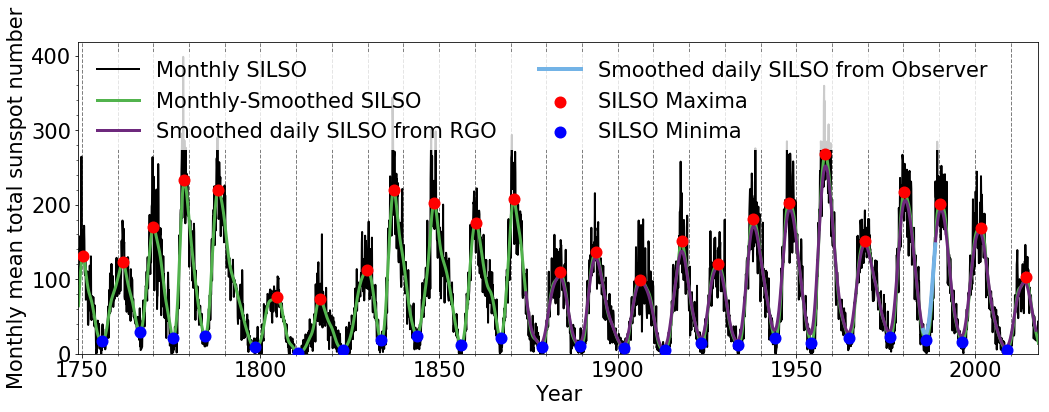

In [57]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2) #plot monthly SN
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MSMOOTH'], color = Clr[3], linewidth = 3) #plot smoothed monthly SN
ax1.scatter(SIL_maxT, SIL_max, color='r', edgecolor='r', alpha = 1, s=100, linewidths = 2, zorder=10) #plot maxima for SILSO
ax1.scatter(SIL_minT, SIL_min, color='b', edgecolor='b', alpha = 1, s=100, linewidths = 2, zorder=10) #plot minima for SILSO

ax1.plot(REF_Grp['FRACYEAR'], REF_Grp['AVGSNd'], color = Clr[2], linewidth = 3) #plot smoothed daily SN_v2 from RGO dataframe
ax1.plot(ObsDat['FRACYEAR'], ObsDat['AVGSNd'], color = Clr[4], linewidth = 4) #plot smoothed daily SN_v2 from the given observer dataframe
#ax1.scatter(REF_minT, REF_min, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10) #plot minima for RGO
#ax1.scatter(REF_maxT, REF_max, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10) #plot maxima for RGO

#ax1.fill(REF_Grp['FRACYEAR'],  risMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[4], color = Clr[4], alpha = 0.3, zorder=15) #plot rising interval
#ax1.fill(REF_Grp['FRACYEAR'],  decMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[2], color = Clr[2], alpha = 0.3, zorder=15) #plot decline interval


#ax1.legend(['Monthly SILSO','Monthly-Smoothed SILSO','Search Window (R)','Search Window (D)','SILSO Maxima', 'SILSO Minima','Extrema in Reference'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')
ax1.legend(['Monthly SILSO','Monthly-Smoothed SILSO','Smoothed daily SILSO from RGO','Smoothed daily SILSO from Observer','SILSO Maxima', 'SILSO Minima','Extrema in Reference'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')

# Axes properties
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly mean total sunspot number')
ax1.set_xlim(left = np.min(SILSO_Sn['FRACYEAR']), right = np.max(SILSO_Sn['FRACYEAR']))
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.minorticks_on()
ax1.set_ylim(bottom = 0);

## Recasting observations into equal intervals of specified duration¶
To simplify and speedup the analysis we segment the observational interval using "months" of arbitrary length. This allows us to reshape our time series into a matrix and perform matrix-vector operations that are much faster than for loops.

Only an integer amount of "months" is used in order to make the reshaping operation possible.

In [58]:
# Number of days per "month"
MoLngt = 30

# OBSERVER
# Selecting the maximum integer amount of "months" out of the original data
grpsOb = ObsDat['GROUPS'].values
grpsOb = grpsOb[0:np.int(grpsOb.shape[0]/MoLngt)*MoLngt] #groups until completing "months" equal to 30 days
#print(grpsOb[0:5,])

ordOb = ObsDat['ORDINAL'].values
ordOb = ordOb[0:np.int(ordOb.shape[0]/MoLngt)*MoLngt]

yrOb = ObsDat['FRACYEAR'].values
yrOb = yrOb[0:np.int(yrOb.shape[0]/MoLngt)*MoLngt]

#the same for daily SN values
SNdOb = ObsDat['AVGSNd'].values
SNdOb = SNdOb[0:np.int(SNdOb.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsOb = grpsOb.reshape((-1,MoLngt))
ordOb  = ordOb.reshape((-1,MoLngt))
yrOb   = yrOb.reshape((-1,MoLngt))
SNdOb  = SNdOb.reshape((-1,MoLngt))

In [59]:
print(grpsOb[0])
print(ordOb[0])
print(yrOb[0])
print(SNdOb)

[2. 2. 2. 2. 2. 4. 3. 3. 4. 3. 3. 2. 1. 0. 1. 1. 1. 1. 1. 1. 2. 2. 0. 0.
 0. 1. 5. 5. 3. 3.]
[724824 724825 724826 724827 724828 724829 724830 724831 724832 724833
 724834 724835 724836 724837 724838 724839 724840 724841 724842 724843
 724844 724845 724846 724847 724848 724849 724850 724851 724852 724853]
[1985.49863014 1985.50136986 1985.50410959 1985.50684932 1985.50958904
 1985.51232877 1985.51506849 1985.51780822 1985.52054795 1985.52328767
 1985.5260274  1985.52876712 1985.53150685 1985.53424658 1985.5369863
 1985.53972603 1985.54246575 1985.54520548 1985.54794521 1985.55068493
 1985.55342466 1985.55616438 1985.55890411 1985.56164384 1985.56438356
 1985.56712329 1985.56986301 1985.57260274 1985.57534247 1985.57808219]
[[ 32.0069052   31.95896918  31.91122696 ...  30.7793146   30.73652906
   30.69394651]
 [ 30.65157328  30.60942046  30.56747047 ...  29.5816308   29.54467815
   29.5079119 ]
 [ 29.47136592  29.43504037  29.39893612 ...  28.56227833  28.53137643
   28.50068405]
 ...
 

# Calculating number of days with observations and number of days with groups

In [60]:
# OBSERVER

# Minimum fraction of observed days for an interval to be considered useful
minObD = 0.33;

# Number of days with observations
obsOb = np.sum(np.isfinite(grpsOb),axis=1)

# Number of days with groups
grpOb = np.sum(np.greater(grpsOb,0),axis=1)

# Average number of groups
Gss_1D_ker = conv.Gaussian1DKernel(2)
AvGrpOb = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker) #monthly average of the smoothed group number
SdGrpOb = np.nanstd(grpsOb,axis=1)

#Average (from daily) sunspot number
#as I did the smoothing above, here, I only do the smoothing to obtain the monthly average from daily sunspot number
#Gss_1D_ker = conv.Gaussian1DKernel(2)
#AvSNdOb = conv.convolve(np.nanmean(SNdOb,axis=1),Gss_1D_ker) #monthly average of the smoothed (daily) sunspot number
AvSNdOb = np.nanmean(SNdOb,axis=1)
SdSNdOb = np.nanstd(SNdOb,axis=1)

# Interval edges for plotting
fyr1Ob = np.min(yrOb,axis=1)
fyr2Ob = np.max(yrOb,axis=1)

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
C:\Users\usuario\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [61]:
print(AvGrpOb)
print(AvSNdOb)

[0.65247588 0.73705632 0.75091036 0.72818017 0.6956369  0.66584874
 0.64906211 0.6491294  0.65405708 0.64675021 0.62612792 0.61097797
 0.62378113 0.67157577 0.73571538 0.77643896 0.76098688 0.70149862
 0.65778481 0.68877037 0.80111997 0.95227798 1.10039187 1.25218486
 1.47952696 1.81923005 2.07823778 2.14299556 2.14346609 2.19966268
 2.3646948  2.63097526 2.93846609 3.21649968 3.44285286 3.65876027
 3.90766763 4.14446136 4.20588019 3.8981824  3.16354979]
[ 31.3375633   30.06676119  28.97251608  28.05941264  27.33180861
  26.79354376  26.44940031  26.30281919  26.35937518  26.62478221
  27.10481194  27.8042116   28.72931018  29.88620431  31.2810778
  32.9186887   34.80508519  36.94420375  39.34000831  41.99578929
  44.91280613  48.09001786  51.52492196  55.21411467  59.15187381
  63.3290799   67.73499059  72.35455759  77.17197718  82.16800698
  87.32134895  92.60732764  98.00029261 103.47167246 108.99257215
 114.53170591 120.05814217 125.5404751  130.9467048  136.2463712
 141.41042163]


## Breaking Observer Period into rising (decaying) Intervals

We break the observational period into cycles going from minimum to maximum, and maximum to minumum, in order to ease the capability of the algorithm to find the best matches during the reference era.
Furthermore, for each rising and decaying interval, we differenciate between low, middle, and high solar activity in order to calculate the active day fraction.

In [62]:
# Minimum ratio of valid "months" for a Min-Max Max-Min interval to be considered useful
vldIntThr = 0.5

# Finding internal endpoints and centers of SILSO

# Assinging max (1) and min (-1) labels to endpoints
#for maxima
maxPointsS = np.expand_dims(SIL_maxT,1) #dates of maxima
maxPointsS = np.concatenate((maxPointsS,maxPointsS*0+1),axis=1) #[dates, 1]
#print(maxPointsS)

#the same for minima
minPointsS = np.expand_dims(SIL_minT,1)
minPointsS = np.concatenate((minPointsS,minPointsS*0-1),axis=1)

# attach and sort max and min dates with 1 and -1
# Creating endpoints matrix
endPointsS = np.append(maxPointsS,minPointsS,axis=0)
# Sorting endpoints
endPointsS = endPointsS[endPointsS[:,0].argsort()]
#print(endPointsS)

# Finding centers and classifying them as rising (1) and decaying (-1)
# average date between max min and min max
cenPointsS = (endPointsS[1:endPointsS.shape[0],:]+endPointsS[0:endPointsS.shape[0]-1,:])/2 
cenPointsS[:,1] = endPointsS[1:endPointsS.shape[0],1]
print(cenPointsS[:,0])
#print(cenPointsS[:,1])

# centers (1->rising, -1->decline) and endpoints(max,min) for RGO according to SILSO dates
# Finding internal endpoints and centers of Reference
endPointsR = endPointsS[np.logical_and(endPointsS[:,0]>np.min(REF_Dat['FRACYEAR']),endPointsS[:,0]<np.max(REF_Dat['FRACYEAR'])),:]
cenPointsR = (endPointsR[1:endPointsR.shape[0],:]+endPointsR[0:endPointsR.shape[0]-1,:])/2
cenPointsR[:,1] = endPointsR[1:endPointsR.shape[0],1]
print(cenPointsR[:,0])


# Finding internal endpoints and centers of Observer Intervals are included if their center is covered by the observer

# Defining boolean array of valid centers
validCen = np.logical_and(cenPointsS[:,0]>np.min(yrOb),cenPointsS[:,0]<np.max(yrOb)); #to identify rising and decline phases (true) in given observer data 
#print(validCen)

# Adding a True on the index prior to the first center to include the bracketing point
validCen[0:validCen.shape[0]-2] = np.logical_or(validCen[0:validCen.shape[0]-2], validCen[1:validCen.shape[0]-1])

# Adding a False at the beggining to account for the difference in size
validCen = np.insert(validCen, 0, False) #add a False
#print(validCen)

# Defining arrays
endPoints = endPointsS[validCen,:] #maxima and minima for the given observer interval according to SILSO dates
print(endPoints)
cenPoints = (endPoints[1:endPoints.shape[0],:]+endPoints[0:endPoints.shape[0]-1,:])/2 #center for given observer interval
#print(cenPoints)
cenPoints[:,1] = endPoints[1:endPoints.shape[0],1] #endpoints(mas min) for given observer with 1 and -1
#print(cenPoints[:,1])


# Identification of Min-Max Max-Min intervals with enough valid "months"
vldIntr = np.zeros(cenPoints.shape[0], dtype=bool) #false if there are enough months in the interval
#print(vldIntr)

for siInx in range(0,cenPoints.shape[0]): #cenPoints are center for given observer
    print(endPoints[siInx,0])
    
    # Redefining endpoints if interval is partial
    # to redefine see if endpoints of given observer are lower or greater than dates for first and last date for given observer
    if endPoints[siInx, 0] < np.min(ObsDat['FRACYEAR']): #the minimum for ObsDat is the first date for given observer->1911
        print('Redefining left endpoint')
        endPoints[siInx, 0] = np.min(ObsDat['FRACYEAR'])
        cenPoints[siInx, 0] = (endPoints[siInx, 0]+endPoints[siInx+1, 0])/2
        
    if endPoints[siInx+1, 0] > np.max(ObsDat['FRACYEAR']):
        print('Redefining right endpoint')
        endPoints[siInx+1, 0] = np.max(ObsDat['FRACYEAR'])
        cenPoints[siInx, 0] = (endPoints[siInx, 0]+endPoints[siInx+1, 0])/2
    
    print('Center:',np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy() #groups from an endpoint to next endpoint for given observer
    #print(TObsDat)
    #print(len(TObsDat))
    
    
    #considering that interval, we define months of 30 days and calculate number of observations->if this amount >=0.33 - valid interval
    # Selecting the maximum integer amount of "months" out of the original data
    TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
    print(TgrpsOb)

    # Reshaping into "months"
    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            

    # Number of days with observations
    ODObs = np.sum(np.isfinite(TgrpsOb),axis=1)
    #print(ODObs)
    #print(minObD)
    
    if np.sum(ODObs/MoLngt>=minObD)/ODObs.shape[0]>=vldIntThr: #if the monthly average of the observation is greater than minObD (0.33=33%) then VALID, if not, INVALID       
        # Marking interval as valid
        vldIntr[siInx] = True
        print('Valid interval. Proportion of valid months: ', np.round(np.sum(ODObs/MoLngt>=minObD)/ODObs.shape[0],2))
        
    else:
        print('INVALID interval. Proportion of valid months: ', np.round(np.sum(ODObs/MoLngt>=minObD)/ODObs.shape[0],2))
        
    print(' ')
        
print(str(np.sum(vldIntr)) + '/' + str(vldIntr.shape[0]) + ' valid intervals')

#print(vldIntr)
if np.sum(vldIntr)==0:
    print('NO VALID INTERVALS IN OBSERVER')
    

[1752.9555 1758.539  1763.8715 1768.165  1772.8325 1777.165  1781.5815
 1786.331  1793.2885 1801.4975 1807.6235 1813.6235 1819.8735 1826.5405
 1831.874  1835.539  1840.539  1846.207  1852.374  1858.207  1863.747
 1869.039  1874.7905 1881.3325 1886.7065 1891.6225 1897.7485 1903.9975
 1909.7055 1915.4985 1920.6645 1925.8305 1930.9565 1935.7905 1940.999
 1946.041  1951.081  1956.1635 1961.4985 1967.039  1972.705  1978.248
 1983.289  1988.246  1993.33   1999.0815 2005.2905 2011.539 ]
[1881.3325 1886.7065 1891.6225 1897.7485 1903.9975 1909.7055 1915.4985
 1920.6645 1925.8305 1930.9565 1935.7905 1940.999  1946.041  1951.081
 1956.1635 1961.4985 1967.039  1972.705  1978.248  1983.289  1988.246
 1993.33   1999.0815 2005.2905 2011.539 ]
[[ 1.986288e+03 -1.000000e+00]
 [ 1.990204e+03  1.000000e+00]]
1986.2879999999998
Redefining right endpoint
Center: 1987.6 Edges: 1986.29 1988.91
[nan nan nan nan  1.  1.  3.  2.  2.  2.  1.  1.  2.  2.  1.  2.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1

# Plotting comparison the observer's active vs. observed days per month

[[0.65247588 0.65247588 0.73705632 0.73705632 0.75091036 0.75091036
  0.72818017 0.72818017 0.6956369  0.6956369  0.66584874 0.66584874
  0.64906211 0.64906211 0.6491294  0.6491294  0.65405708 0.65405708
  0.64675021 0.64675021 0.62612792 0.62612792 0.61097797 0.61097797
  0.62378113 0.62378113 0.67157577 0.67157577 0.73571538 0.73571538
  0.77643896 0.77643896 0.76098688 0.76098688 0.70149862 0.70149862
  0.65778481 0.65778481 0.68877037 0.68877037 0.80111997 0.80111997
  0.95227798 0.95227798 1.10039187 1.10039187 1.25218486 1.25218486
  1.47952696 1.47952696 1.81923005 1.81923005 2.07823778 2.07823778
  2.14299556 2.14299556 2.14346609 2.14346609 2.19966268 2.19966268
  2.3646948  2.3646948  2.63097526 2.63097526 2.93846609 2.93846609
  3.21649968 3.21649968 3.44285286 3.44285286 3.65876027 3.65876027
  3.90766763 3.90766763 4.14446136 4.14446136 4.20588019 4.20588019
  3.8981824  3.8981824  3.16354979 3.16354979]]
[[ 31.3375633   31.3375633   30.06676119  30.06676119  28.97251608
 

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater


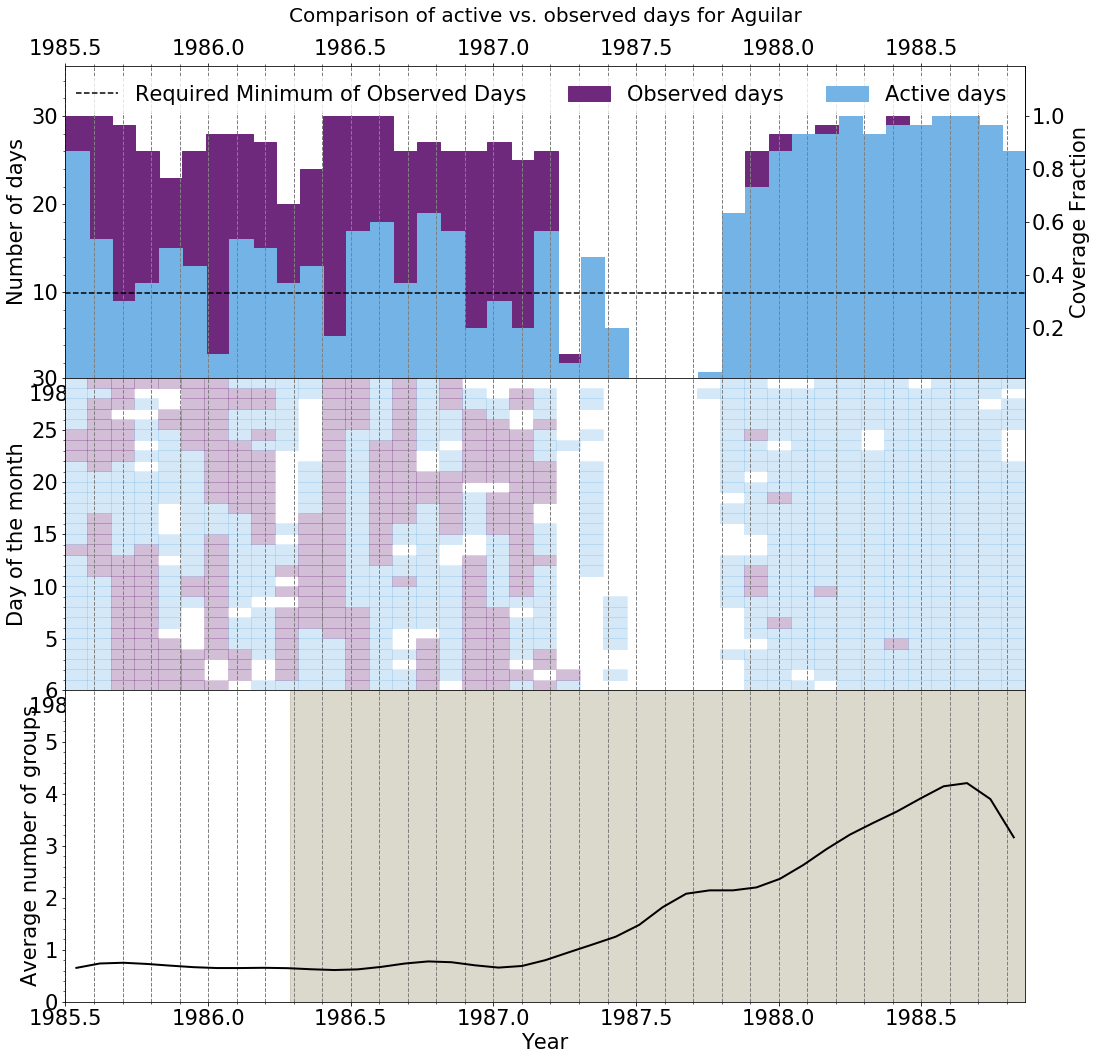

In [63]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltxOb = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltxOb = np.append(pltxOb,np.max(fyr2Ob))
pltxOb = np.append(pltxOb,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAvOb = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')
pltyAvSNd = np.stack((AvSNdOb,AvSNdOb)).reshape((1,-1),order='F')
pltySdSNd = np.stack((SdSNdOb,SdSNdOb)).reshape((1,-1),order='F')
print(pltyAvOb)
print(pltyAvSNd)


# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAvOb = np.insert(pltyAvOb,0,0)
pltyAvOb = np.append(pltyAvOb,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

pltyAvSNd = np.insert(pltyAvSNd,0,0)
pltyAvSNd = np.append(pltyAvSNd,0)

pltySdSNd = np.insert(pltySdSNd,0,0)
pltySdSNd = np.append(pltySdSNd,0)


plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltxOb, pltyOb, color = Clr[2])
ax1.fill(pltxOb, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

ax1.plot(np.array([np.min(pltxOb),np.max(pltxOb)]), np.array([1,1])*minObD*MoLngt, 'k--')



# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Required Minimum of Observed Days','Observed days','Active days'], loc = 'upper right', ncol = 3, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

#to plot the rising (purple) and decline (blue) phases
for Idx in range(0,cenPoints.shape[0]):
    if vldIntr[Idx]:
        ax3.fill([endPoints[Idx, 0], endPoints[Idx, 0], endPoints[Idx+1, 0], endPoints[Idx+1, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1, np.ceil(np.nanmax(AvGrpOb))+1, 0 ], color = Clr[1+np.mod(Idx,2)*2], alpha = 0.2)

ax3.plot((fyr1Ob+fyr2Ob)/2, AvGrpOb, color = Clr[0], linewidth = 2)



# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0, top = np.ceil(np.nanmax(AvGrpOb))+1);

FIGURE: Top: Number of active (non-zero; blue) and observed (purple) days during each month.

Middle: Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue). The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

Bottom: Average number of groups each month. Shaded areas indicate the separation of observations in sub-domains roughly going from maximum to maximum. White intervals are not used in calibration due to the interval being too small or not having good coverage


## Calculating the solar minimum masks that will be used in the optimization scan for best match
Given that our objective is to calculate the relative of different cycles we can take advantage of our knowledge of cycle progression to narrow the search for an optimum. To do this we create a mask of valid search periods determined by using a window centered on the minima contained within the reference data.

In [64]:
# Temporal Stride in days
dt = 30

# Cycle phase tolerance in years
phTol = 2

# Number of thresholds including 0
thN = 50

# Threshold increments ##I changed "thI=1" by "thI=2"
thI = 1

# Creating window masks
risMask = np.zeros(REF_Grp.shape[0], dtype=bool) #mask with zero numbers equal to the len of RGO groups (REF_Grp)
#print(len(risMask))
decMask = np.zeros(REF_Grp.shape[0], dtype=bool) #mask with zero numbers equal to the len of RGO groups (REF_Grp)
#print(len(decMask))

# Applying mask
for cen in cenPointsR: #cenPointsR are the center in rising and decline phase for RGO data 
    #print(cen[1])
    if cen[1]==1: #cen[0]=dates; cen[1]=1->MAXIMA and -1->MINIMA according to cenPointsR for RGO data
        risMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True
    else:
        decMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True
#risMask=true if RGO center points is in rising phase and between two years before and after with respect to the SILSO center point date (we have 2-year interval because we know it will be always fulfilled)
#decMask=true if RGO center points is in decline phase and between two years before and after with respect to the SILSO center point date (we have 2-year interval because we know it will be always fulfilled)
#print(risMask[4500:4550])
#print(decMask[4500:4550])

# Creating cadence mask
cadMask = np.zeros(REF_Grp.shape[0], dtype=bool)
cadMask[range(0,cadMask.shape[0],dt)] = True #create zero each 30 steps->each 30 positions, one True (rest are false) (len=Len of RGO)
#print(cadMask[0:65])

#Storing maks for plotting
risMaskP = risMask.copy()
decMaskP = decMask.copy()
#print(risMask)
#print(decMask)

# Creating rising mask
risMask = np.logical_and(cadMask,risMask) #True when true in cadMask and risMask, rest of cases are false
#print(risMask[1800:2000])

# Creating decaying mask
decMask = np.logical_and(cadMask,decMask) #True when true in cadMask and risMask, rest of cases are false
#print(decMask)
#therefore, from two years before to two years after of the center points, we have "true" each 30 positions, rest are false
#this is to set the beginning of the months to calculate later mean, sum, etc???

# Turnings Mask into indices
# convert true values to ordinals
risMaskI = np.array(risMask.nonzero()[0])
#print(risMaskI)
decMaskI = np.array(decMask.nonzero()[0])
#print(decMaskI)

In [65]:
print(len(risMaskI))

633


# Plotting maxima, minima, and search windows

'THE GREY LINE IS PART OF MONTHLY SILSO AND IT HAS THIS COLOR BECAUSE IS BEHIND THE LEGEND'

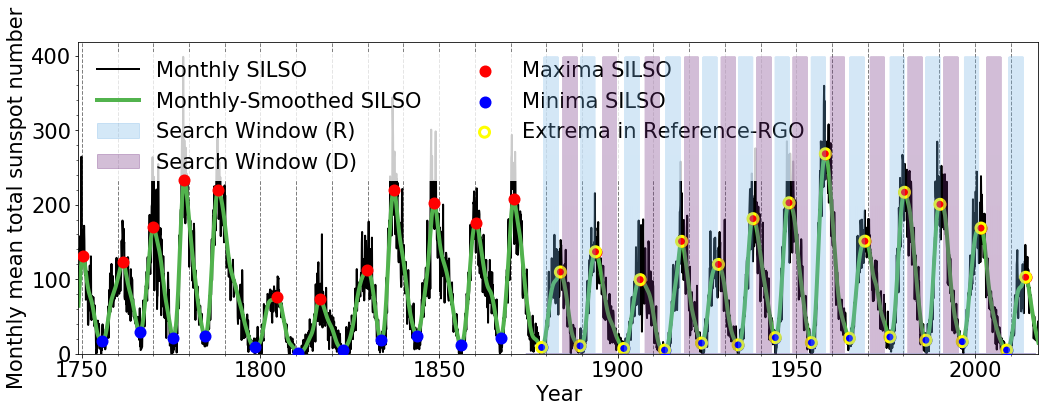

In [66]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2) #plot monthly SN
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MSMOOTH'], color = Clr[3], linewidth = 4) #plot smoothed monthly SN
ax1.scatter(SIL_maxT, SIL_max, color='r', edgecolor='r', alpha = 1, s=100, linewidths = 2, zorder=10) #plot maxima for SILSO
ax1.scatter(SIL_minT, SIL_min, color='b', edgecolor='b', alpha = 1, s=100, linewidths = 2, zorder=10) #plot minima for SILSO
ax1.scatter(REF_minT, REF_min, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10) #plot minima for RGO
ax1.scatter(REF_maxT, REF_max, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10) #plot maxima for RGO
ax1.fill(REF_Grp['FRACYEAR'],  risMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[4], color = Clr[4], alpha = 0.3, zorder=15) #plot rising interval
ax1.fill(REF_Grp['FRACYEAR'],  decMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[2], color = Clr[2], alpha = 0.3, zorder=15) #plot decline interval


ax1.legend(['Monthly SILSO','Monthly-Smoothed SILSO','Search Window (R)','Search Window (D)','Maxima SILSO', 'Minima SILSO','Extrema in Reference-RGO'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')

# Axes properties
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly mean total sunspot number')
ax1.set_xlim(left = np.min(SILSO_Sn['FRACYEAR']), right = np.max(SILSO_Sn['FRACYEAR']))
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.minorticks_on()
ax1.set_ylim(bottom = 0);

'''THE GREY LINE IS PART OF MONTHLY SILSO AND IT HAS THIS COLOR BECAUSE IS BEHIND THE LEGEND'''

FIGURE: Maxima and minima determinid using SILSO's v2 series. This help us reduce significantly the number of steps on the optimization scan. This way, rising (decaying) phases of the observer only need to be compared with rising (decaying) phasis of the reference

## Distributions of active day fractions and observed day fractions for given observer
The active day fraction method identifies the detection threshold of a given observer by identifying the closest cumulative distribution function observed in the reference data after applying varying thresholds. The concern is that focusing on the active day fraction only, without looking at the observed day fraction, may yield erroneous thresholds. The distributions for the given observer look like this:

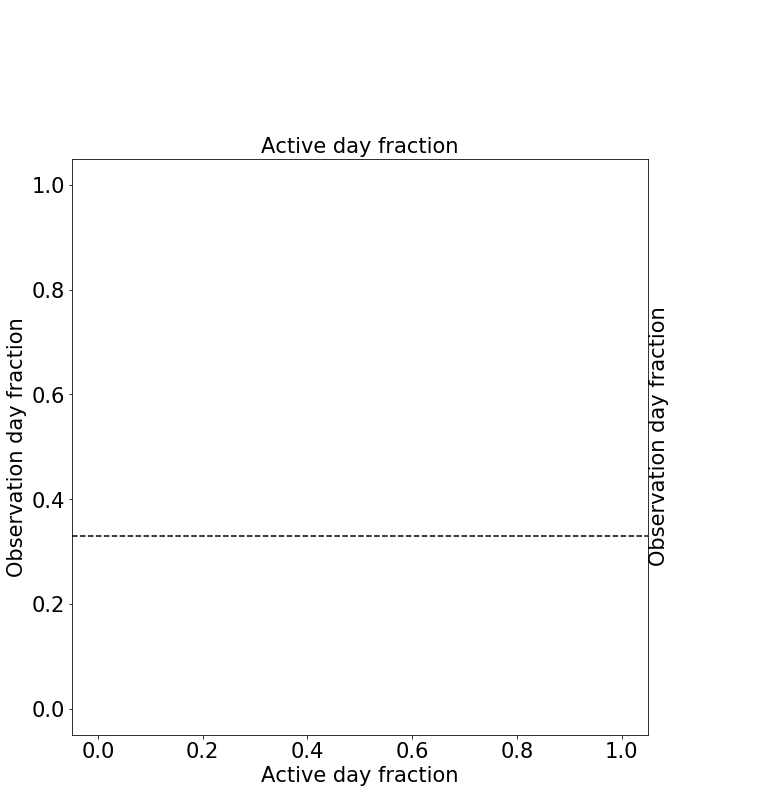

In [67]:
# Distribution Plots for Observer

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Top Distribution
axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
#ADFObs, bins, patches = axd.hist(grpOb[obsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[4], alpha=.6, normed = True);

# Axes properties
axd.set_xlim(left = -0.05, right = 1.05);
axd.set_axis_off()


# Right Distribution
ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
#ax2.hist(obsOb[obsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);

# Axes properties
ax2.set_ylim(bottom = -0.05, top = 1.05);
ax2.set_axis_off()

# Scatter Plot
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
#ax1.scatter(grpOb/MoLngt, obsOb/MoLngt, color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)
ax1.plot(np.array([-0.05,1.05]), np.array([1,1])*minObD, 'k--')

# Axes properties
ax1.set_ylabel('Observation day fraction')
ax1.text(1.02, 0.52,'Observation day fraction', horizontalalignment='center', transform = ax1.transAxes, 
         rotation = 'vertical', verticalalignment = 'center')
ax1.set_xlabel('Active day fraction')
ax1.text(0.5, 1.01,'Active day fraction', horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = -0.05, right = 1.05)
ax1.set_ylim(bottom = -0.05, top = 1.05);

FIGURE: Scatter plot connecting the active day and observed day fraction, as well as the marginal distributions for each of the quantities. Colored areas indicate the distributions for the given observer. The horizontal dashed line shows the minimum threshold of days with observations below which we don't include points in the ADF distribution.

## Calculating number of active and observed days
For each of the observer subintervals specified in "Breaking Observer Period into rising (decaying) Intervals" we do a window scan during the rising (decays) contained in the reference. For each step in the window scan we:

Select an interval in the reference of equal duration as in the observer's sub-interval.
Imprint missing days on both reference and observer
Calculate number of active days and number of days with observations

In [68]:
# Low-medium-high activity threshold
#lowth=50
#highth=100

# Creating Storing dictionaries
# Number of days with groups
GDObsI = []
GDREFI = []  

# Number of days with observations
ODObsI = []    
ODREFI = [] 

# Number of days without observations
QDObsI = []
QDREFI = []

# Monthly (from daily) sunspot number
SNdObsI = []

#creating storing dictionaries for ADF
ADFObsI = []
ADFREFI = []


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]): #cenPoints=[date, +1/-1] is centerpoint for given observer and cenPoints.shape[0]=3->for from 0 to 3
#for siInx in range(0,1):    
    
    print('Center:', np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Perform analysis Only if the period is valid
    if vldIntr[siInx]: #in the case of given observer, the three interval are valid
    
        print('Valid Interval')
        
        #print(cenPointsR)
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0: #if the center points are 1, then risMaskI, else (if -1), decMaskI
            cadMaskI = risMaskI
        else:
            cadMaskI = decMaskI
        #cadMaskI is the mask for rising and decline phase using RGO data
        #print(len(risMaskI))
        #print(len(cadMaskI))

        # Selecting interval
        #interval according to given observer data
        TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'GROUPS'].values.copy()
        TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'FRACYEAR'].values.copy()
        
        TObsSNd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'AVGSNd'].values.copy()
      
        
        #TObsDat are group number from one endpoint to the next one and TObsFYr are the same but in dates
        #tObsSNd is the SNd values from one endpoint to the next one
        #print(TObsSNd[0:10])
        #print(len(TObsDat))
        #print(TObsDat)
        #print(len(TObsDat))
        #print(TObsFYr)
        #print(len(TObsFYr))

        # Find index of center of sub-interval
        minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx, 0]))
        #print(TObsFYr)
        #print(cenPoints[siInx, 0]) #->1915.5
        #print(minYear)
        obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx, 0])==minYear).nonzero()[0][0] #this is the center of the interval for given observer
        #print(obsMinInx)

        # Creating Storing Variables
        # Number of days with groups
        GDObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) #mask with zeros?   
        GDREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) #mask with zeros?
        #print(len(GDObs))
        #print(GDREF)

        # Number of days with observations
        ODObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) #mask with zeros?   
        ODREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) #mask with zeros?    
        
        # mask for monthly ADF
        ADFObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) #mask with zeros?
        ADFREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) #mask with zeros?

        # Going through different thresholds
        # to do proofs: thN=1
        for TIdx in range(0,thN): #thN=50 and thI=2
        #for TIdx in range(0,1):
            # Calculating number of groups in reference data for given threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thI) ,axis = 1).astype(float)
            #print(grpsREFw)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
            #print(len(grpsREFw))
            
            #defining low and high solar activity level
#            print(thI)
#            print(TIdx*thI)
            highth=0.18*TIdx*thI+31.8
#            print(highth)
            if TIdx*thI>=60: 
                lowth = 0.19333333*TIdx*thI-2.66666667
            else:
                lowth = 0
#            print(lowth)

            # Going through different shifts
            #shifts=subintervals (rising and decline)
            #to calculate number of groups and observations for RGO for each subinterval and the given observer
            for SIdx in range(0,cadMaskI.shape[0]): #cadMaskI.shape[0] give an integer (633) -> cadMaskI (mask using RGO data for rising and decline) are ordinals with a 30 positions separation between each element for subinterval 
            #for SIdx in range(0,1):
                
                # Selecting the maximum integer amount of "months" out of the original data
                TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy() ##TObsDat are groups from an endpoint to next endpoint for given observer

                TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy() ##TObsDat are (daily) sunspot number values from an endpoint to next endpoint for given observer
#                print(TObsSNd[0:30])
#                print(TgrpsOb[0:30])
                
                #Calculating bracketing indices
                #to iniciate to distance equal to the center of the interval for given observer???
                Idx1 = cadMaskI[SIdx]-obsMinInx
                #print(cadMaskI[SIdx])
                #print(obsMinInx)
                #print(Idx1)
                Idx2 = Idx1 + TgrpsOb.shape[0] #initial point (Idx1) + data with length = length given observer data
                #print(TgrpsOb.shape[0])
                #print(Idx2)

                #Selecting reference window of matching size to observer sub-interval;
                TgrpsREF = grpsREFw[Idx1:Idx2].copy()
                #print(TgrpsREF)
                TSNdREF = REF_Grp['AVGSNd'][Idx1:Idx2].values.copy()

                # Making sure selections have the same length
                if TgrpsREF.shape[0] == TgrpsOb.shape[0]:

                    # Reshaping into "months"
                    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))   #daily groups for subinterval using given observer. length = 57 months (30 data per elements)        
                    TgrpsREF = TgrpsREF.reshape((-1,MoLngt)) #values changes according to the mask (different subinterval of the RGO series)
                    
                    TObsSNd = TObsSNd.reshape((-1,MoLngt))   #(daily) sunspot number for subinterval using given observer. length = 57 months (30 data per elements)        
                    TSNdREF = TSNdREF.reshape((-1,MoLngt))
#                    print(TObsSNd[0])
#                    print(TgrpsOb[0])
#                    print(len(TObsSNd))
#                    print(len(TgrpsOb))
#                    print(TgrpsREF[0]) #I do not know which is this first dataset because it is not for the same period that the given observer subinterval

                    # Imprinting missing days ---->>>> to match nan in both distributions???
                    # OBSERVER
                    TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                    # REFERENCE
                    TgrpsREF[np.isnan(TgrpsOb)] = np.nan
#                    print(TgrpsOb[0])
                    #print(TgrpsREF[0])
                    

                    # Number of days with groups
                    # OBSERVER
                    GDObs[TIdx,SIdx,:] = np.sum(np.greater(TgrpsOb,0),axis=1)
                    # REFERENCE
                    GDREF[TIdx,SIdx,:] = np.sum(np.greater(TgrpsREF,0),axis=1)
#                    print(GDObs[TIdx,SIdx,:])
                    #print(GDREF[0,0])

                    # Number of days with observations
                    # OBSERVER
                    ODObs[TIdx,SIdx,:] = np.sum(np.isfinite(TgrpsOb),axis=1)
                    #ODObs[TIdx,SIdx,:] = np.sum(TgrpsOb)
                    # REFERENCE
                    ODREF[TIdx,SIdx,:] = np.sum(np.isfinite(TgrpsREF),axis=1)
#                    print(ODObs[TIdx,SIdx,:])
                    
                    # Number of quiet days
                    # OBSERVER
                    QDObs = ODObs-GDObs
                    # REFERENCE
                    QDREF = ODREF-GDREF
#                    print(QDObs)
                    
                    # monthly (from daily) sunspot number
                    #SNdObs[TIdx,SIdx,:] = np.mean(np.isfinite(TObsSNd),axis=1)
                    SNdObs = np.mean(TObsSNd,axis=1) 
                    SNdREF = np.mean(TSNdREF,axis=1)
#                    print(SNdObs)
                    #print(SNdObs)
#                    print(SNdObs[0,0])
#                    print(SNdObs[0,0,0])
#                    print(len(SNdObs[0,0]))
                    #print(SNdObs[siInx,TIdx,SIdx])
#                    print(SNdObs[TIdx,SIdx,:])
                                        
#                    print(siInx)
#                    print(TIdx)
#                    print(SIdx)

#                    print(SNdObs[TIdx,SIdx])
#                    print(SNdObs[TIdx,SIdx,:])
                    LMObs=SNdObs<=lowth
                    LMRef=SNdREF<=lowth
#                    lowval=SNdObs[lowmsk]
#                    print(lowmsk)
#                    print(lowval)
                    MMObs=np.logical_and((lowth<SNdObs), (SNdObs<highth))
                    MMRef=np.logical_and((lowth<SNdREF), (SNdREF<highth))
#                    medval=SNdObs[medmsk]
#                    medval=SNdObs[TIdx,SIdx][np.where((50<SNdObs[TIdx,SIdx]) & (SNdObs[TIdx,SIdx]<100))]
#                    print(medmsk)
#                    print(medval)
                    HMObs=(SNdObs>=highth)
                    HMRef=(SNdREF>=highth)
#                    highval=SNdObs[highmsk]
#                    print(highmsk)
#                    print(highval)
                    #highval=SNdObs[TIdx,SIdx][np.where(SNdObs[TIdx,SIdx]>=100)]

                    
#                    print(GDObs[TIdx,SIdx])
#                    print('low activity level')
#                    print(GDObs[TIdx,SIdx][lowpos])
                    #ADFObs[TIdx,SIdx,lowmsk]=GDObs[TIdx,SIdx][lowmsk]/MoLngt
                    #ADFREF[TIdx,SIdx,lowmsk]=GDREF[TIdx,SIdx][lowmsk]/MoLngt
#                    print(GDObs[TIdx,SIdx][lowmsk])
                    ADFObs[TIdx,SIdx,LMObs]=GDObs[TIdx,SIdx][LMObs]/MoLngt
                    ADFREF[TIdx,SIdx,LMRef]=GDREF[TIdx,SIdx][LMRef]/MoLngt
#                    print('medium activity level')
#                    print(GDObs[TIdx,SIdx][medpos])
#                    print(ODObs[TIdx,SIdx][medpos])
                    ADFObs[TIdx,SIdx,MMObs]=GDObs[TIdx,SIdx][MMObs]/ODObs[TIdx,SIdx][MMObs]
                    ADFREF[TIdx,SIdx,MMRef]=GDObs[TIdx,SIdx][MMRef]/ODREF[TIdx,SIdx][MMRef]
#                    print('high activity level')
#                    print(QDObs[TIdx,SIdx][highpos])
                    ADFObs[TIdx,SIdx,HMObs]=(MoLngt-QDObs[TIdx,SIdx][HMObs])/MoLngt
                    ADFREF[TIdx,SIdx,HMRef]=(MoLngt-QDREF[TIdx,SIdx][HMRef])/MoLngt
                    
#                    ADFObsold=np.concatenate([ADFObsl,ADFObsm,ADFObsh])
#                    ADFREFold=np.concatenate([ADFREFl,ADFREFm,ADFREFh])
                    
                    #DFObs[TIdx,SIdx,:] = ADFObsold
                    #DFREF[TIdx,SIdx,:] = ADFREFold
#                    print(ADFObs)
                    #print(ADFREF)
                                       
                        
    # If period is not valid append empty variavbles
    else:        
        print('INVALID Interval')        
        GDObs = []
        GDREF = []
        ODObs = []
        ODREF = []
        
        QDObs = []
        QDREF = []
        SNdObs = []
        
        ADFObs = []
        ADFREF = []
        
    print(' ')
  
    
    # Appending calculated days to list of sub-intervals
    GDObsI.append(GDObs) # monthly number of day with groups for given observer and threshold (there are 50 threshold) during the subinterval
    #print(GDObs)
    GDREFI.append(GDREF)
    ODObsI.append(ODObs)
    ODREFI.append(ODREF)
    
    QDObsI.append(QDObs)
    QDREFI.append(QDREF)
    SNdObsI.append(SNdObs)
    #print(SNdObs)
    
    ADFObsI.append(ADFObs)
    ADFREFI.append(ADFREF)

#print(GDObs[0,632])
#print(ODObs)
#print(len(GDObs[0]))

#print(TgrpsOb[0])
#print(TgrpsREF[0])

print(GDObs)
print(QDObs)
print(ODObs)
#print(SNdObs)
print(ADFObs)
#print(ADFREF)
#print(ADFObs[0,0])
#print(ADFObs[0,1])

#to calculate group and observation numbers for RGO and given observer for each RGO subinterval according to the length of given observer data and nan positions for both distribution
#finally to each centerpoint for given observer, we calculate the number of groups and observations for different thresholds and according to observations in each subinterval, rising and decline, for given observer and RGO
#taking into account that for each subinterval both distributions must have nan in the same positions. Therefore, given observer data are always similar (data are the same and only changes according to nan positions of each RGO subinterval) and RGO


Center: 1987.6 Edges: 1986.29 1988.91
Valid Interval


C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:235: RuntimeWarning: invalid value encountered in true_divide


 
[[[15. 10. 11. ... 29. 30. 26.]
  [15.  9. 10. ... 30. 27. 26.]
  [15. 10. 11. ... 27. 27. 29.]
  ...
  [15.  9. 11. ... 27. 30. 27.]
  [13.  9. 10. ... 30. 28. 29.]
  [13.  9. 11. ... 28. 30. 26.]]

 [[15. 10. 11. ... 29. 30. 26.]
  [15.  9. 10. ... 30. 27. 26.]
  [15. 10. 11. ... 27. 27. 29.]
  ...
  [15.  9. 11. ... 27. 30. 27.]
  [13.  9. 10. ... 30. 28. 29.]
  [13.  9. 11. ... 28. 30. 26.]]

 [[15. 10. 11. ... 29. 30. 26.]
  [15.  9. 10. ... 30. 27. 26.]
  [15. 10. 11. ... 27. 27. 29.]
  ...
  [15.  9. 11. ... 27. 30. 27.]
  [13.  9. 10. ... 30. 28. 29.]
  [13.  9. 11. ... 28. 30. 26.]]

 ...

 [[15. 10. 11. ... 29. 30. 26.]
  [15.  9. 10. ... 30. 27. 26.]
  [15. 10. 11. ... 27. 27. 29.]
  ...
  [15.  9. 11. ... 27. 30. 27.]
  [13.  9. 10. ... 30. 28. 29.]
  [13.  9. 11. ... 28. 30. 26.]]

 [[15. 10. 11. ... 29. 30. 26.]
  [15.  9. 10. ... 30. 27. 26.]
  [15. 10. 11. ... 27. 27. 29.]
  ...
  [15.  9. 11. ... 27. 30. 27.]
  [13.  9. 10. ... 30. 28. 29.]
  [13.  9. 11. ... 28. 30.

In [69]:
np.sum(SNdObs - SNdREF )

-669.24890521991

In [70]:
print(GDObs[0,0])
print(GDObs[0,1])
print(len(GDObs))
print(len(GDObs[0,:]))
print(GDObs[0,:])
#print(SNdObs)
#print(GDObsI[0])
##print(ODObsI[0][0,0,:])
##print(TgrpsOb[0])
##print(TgrpsREF[0])

#print(SNdObs)
#print(GDObs)

[15. 10. 11. 16. 17. 11. 18.  9.  9.  8. 11.  7.  7. 12.  0.  0.  0.  0.
  7. 21. 23. 24. 25. 27. 29. 27. 29. 29. 29. 30. 26.]
[15.  9. 10. 18. 15. 10. 19.  9.  9.  8. 10.  7.  9. 11.  0.  0.  0.  0.
  8. 21. 23. 25. 24. 29. 30. 26. 30. 28. 30. 27. 26.]
50
633
[[15. 10. 11. ... 29. 30. 26.]
 [15.  9. 10. ... 30. 27. 26.]
 [15. 10. 11. ... 27. 27. 29.]
 ...
 [15.  9. 11. ... 27. 30. 27.]
 [13.  9. 10. ... 30. 28. 29.]
 [13.  9. 11. ... 28. 30. 26.]]


## The Earth Mover's Distance (Wasserstein metric)
As part of our effort to make ADF more robust we introduce the Earth Mover's distance (EMD) to quantify how different are the Observer's and reference's distribution of ADFs.

See description paper here

The basic idea of the EMD is to depict distributions as piles of dirt and quantify the amount of "work" that an earth mover would need to do in order to transform one distribution into the other. Here we use the pyemd package:

https://github.com/wmayner/pyemd

## Calculating the Earth's Mover Distance using a sliding window
The idea is to optimize the fit between the reference and different sections of the observer's ADF distributions simultaneously in time and threshold. The cell below performs this operation. We use prior knowledge of cycle progression to limit the search to periods around cycle minimum (the centerpoints of our sub-intervals).

In [71]:
from pyemd import emd

# Creating Storing dictionaries for distance matrices
EMDD = []
EMDtD = [] 
EMDthD = []

#creating storing dictionaries for ADF
#ADFObsI = []
#ADFREFI = []

# Calculation of distance matrix to be used in the Earth Movers Metric
x = np.arange(0,MoLngt+1)
y = np.arange(0,MoLngt+1)
xx, yy = np.meshgrid(x, y)
Dis = np.absolute(np.power(xx-yy,1))

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]): #cenPoints=[date, +1/-1] is centerpoint for given observer and cenPoints.shape[0]=3->for from 0 to 3
#for siInx in range(0,1):

    
    print('Center:', np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Perform analysis Only if the period is valid
    if vldIntr[siInx]: #in the case of given observer, the three interval are valid
    
        print('Valid Interval')
        
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0:
            cadMaskI = risMaskI
        else:
            cadMaskI = decMaskI          
            #cadMaskI is the mask for rising and decline phase using RGO data
            
        # Pre-allocating EMD matrix and associated coordinate matrices.  A large default distance valued is used 
        # to account for missing points
        EMD   = np.ones((GDREFI[siInx].shape[0],GDREFI[siInx].shape[1]))*1e16
        EMDt  = np.zeros((GDREFI[siInx].shape[0],GDREFI[siInx].shape[1]))
        EMDth = np.zeros((GDREFI[siInx].shape[0],GDREFI[siInx].shape[1]))
        

        # Going through different thresholds
        for TIdx in range(0,thN): #thN=50 and thI=2
        #for TIdx in range(0,1):

            # Going through different shifts
            #shifts=subintervals (rising and decline)
            #to calculate EMD berween RGO and the given observer for each subinterval
            for SIdx in range(0,cadMaskI.shape[0]): #cadMaskI.shape[0] give an integer (633) -> cadMaskI (mask using RGO data for rising and decline) are ordinals with a 30 positions separation between each element for subinterval 
            #for SIdx in range(0,1):              
                
#                print(siInx)
#                print(TIdx)
#                print(SIdx)
#                #print(GDObsI[siInx])
#                print(GDObsI[siInx][TIdx,SIdx,:])
#                print(QDObsI[siInx][TIdx,SIdx,:])
#                print(ODObsI[siInx][TIdx,SIdx,:])
#                print(TgrpsOb[0])
#                print(TgrpsREF[0])
#                #print(GDREFI[siInx][TIdx,SIdx,:])
#                #print(QDREFI[siInx][TIdx,SIdx,:])
#                #print(ODREFI[siInx][TIdx,SIdx,:])
#                print(SNdObsI[siInx][TIdx,SIdx,:])
#                #print(GDObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD])
#                #print(GDREFI[siInx][TIdx,SIdx,ODREFI[siInx][TIdx,SIdx,:]/MoLngt>=minObD])
                
                if np.any(ODObsI[siInx][TIdx,SIdx,:]!=0) and np.any(ODREFI[siInx][TIdx,SIdx,:]!=0):
                
                    # Calculating Earth Mover's Distance
                    ADFObsDis, bins = np.histogram(
                        ADFObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
                        
                    ADFREFDis, bins = np.histogram(
                        ADFREFI[siInx][TIdx,SIdx,ODREFI[siInx][TIdx,SIdx,:]/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)                             
                                  
                   
                    EMD[TIdx,SIdx] = emd(ADFREFDis.astype(np.float64),ADFObsDis.astype(np.float64),Dis.astype(np.float64))
                    #print(EMD[TIdx,SIdx])
                    #print(ADFObs) #the length of ADFObs is 31 and for (GDObsI[siInx][TIdx,SIdx,:]/ODObsI[siInx][TIdx,SIdx,:]) is 57 (like the length of the first subinterval for Moye)
                    #print(GDObsI[siInx][TIdx,SIdx,:]/ODObsI[siInx][TIdx,SIdx,:])
                    #print(GDObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD]/ODObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD])
                    #print(GDObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt]/ODObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD])
                    #print(ADFREF)
                #print(ADFObs)
                #print(ADFREF)
                
                   
                    
    #                 #Calculating Chi-Square distance
    #                 ADFObs, bins = np.histogram(GDObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)
    #                 ADFREF, bins = np.histogram(GDREFI[siInx][TIdx,SIdx,ODREFI[siInx][TIdx,SIdx,:]/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)

    #                 # Calculating numerator and denominator for Chi-square distance
    #                 Nom = np.power(ADFObs-ADFREF,2)
    #                 #Den = np.power(ADFObs,2) + np.power(ADFREF,2)
    #                 Den = ADFObs + ADFREF

    #                 # Removing zeros in denominator
    #                 Nom = Nom[Den!=0]
    #                 Den = Den[Den!=0]

    #                 # Calculating Chi-square distance
    #                 EMD[TIdx,SIdx] = np.sum(np.divide(Nom,Den))

                # Storing coordinates of EMD distances
                EMDt[TIdx,SIdx] = REF_Grp['FRACYEAR'].values[cadMaskI[SIdx]]
                EMDth[TIdx,SIdx]= TIdx*thI
                        
    # If period is not valid append empty variables
    else:        
        print('INVALID Interval')
        EMD = []
        EMDt = []
        EMDth = []
    
    print(' ')
    
    EMDD.append(EMD)
    EMDtD.append(EMDt)
    EMDthD.append(EMDth)
    
print(EMD)
print(EMDt)
print(EMDth)

Center: 1987.6 Edges: 1986.29 1988.91
Valid Interval
 
[[116.399916 111.599928 106.799868 ... 201.599928 205.200036 206.399988]
 [116.399916 111.599928 106.799868 ... 201.599928 205.200036 206.399988]
 [116.399916 111.599928 106.799868 ... 201.599928 205.200036 206.399988]
 ...
 [ 71.999964  71.999928  73.199952 ... 206.399952 207.600048 211.200012]
 [ 71.999964  71.999928  73.199952 ... 205.199964 206.40006  211.200012]
 [ 71.999964  71.999928  73.199952 ... 203.99994  205.200036 209.999988]]
[[1879.38356164 1879.46575342 1879.54794521 ... 2013.34794521
  2013.43013699 2013.51232877]
 [1879.38356164 1879.46575342 1879.54794521 ... 2013.34794521
  2013.43013699 2013.51232877]
 [1879.38356164 1879.46575342 1879.54794521 ... 2013.34794521
  2013.43013699 2013.51232877]
 ...
 [1879.38356164 1879.46575342 1879.54794521 ... 2013.34794521
  2013.43013699 2013.51232877]
 [1879.38356164 1879.46575342 1879.54794521 ... 2013.34794521
  2013.43013699 2013.51232877]
 [1879.38356164 1879.46575342 1

In [72]:
#print(EMD)
#print(EMDt)
#print(EMDth)

## Plotting the optimization matrix between reference and observer for each sub-interval separately
For comparison, if the observer has a coincident time with the reference, we also calculate the EMD using exact matches.

hello
hello
31.8
0
31.98
0
32.160000000000004
0
32.34
0
32.52
0
32.7

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in greater



0
32.88
0
33.06
0
33.24
0
33.42
0
33.6
0
33.78
0
33.96
0
34.14
0
34.32
0
34.5
0
34.68
0
34.86
0
35.04
0
35.22
0
35.4
0
35.58
0
35.76
0
35.94
0
36.120000000000005
0
36.3
0
36.480000000000004
0
36.66
0
36.84
0
37.02
0
37.2
0
37.38
0
37.56
0
37.74
0
37.92
0
38.1
0
38.28
0
38.46
0
38.64
0
38.82
0
39.0
0
39.18
0
39.36
0
39.54
0
39.72
0
39.9
0
40.08
0
40.26
0
40.44
0
40.620000000000005
0
hello


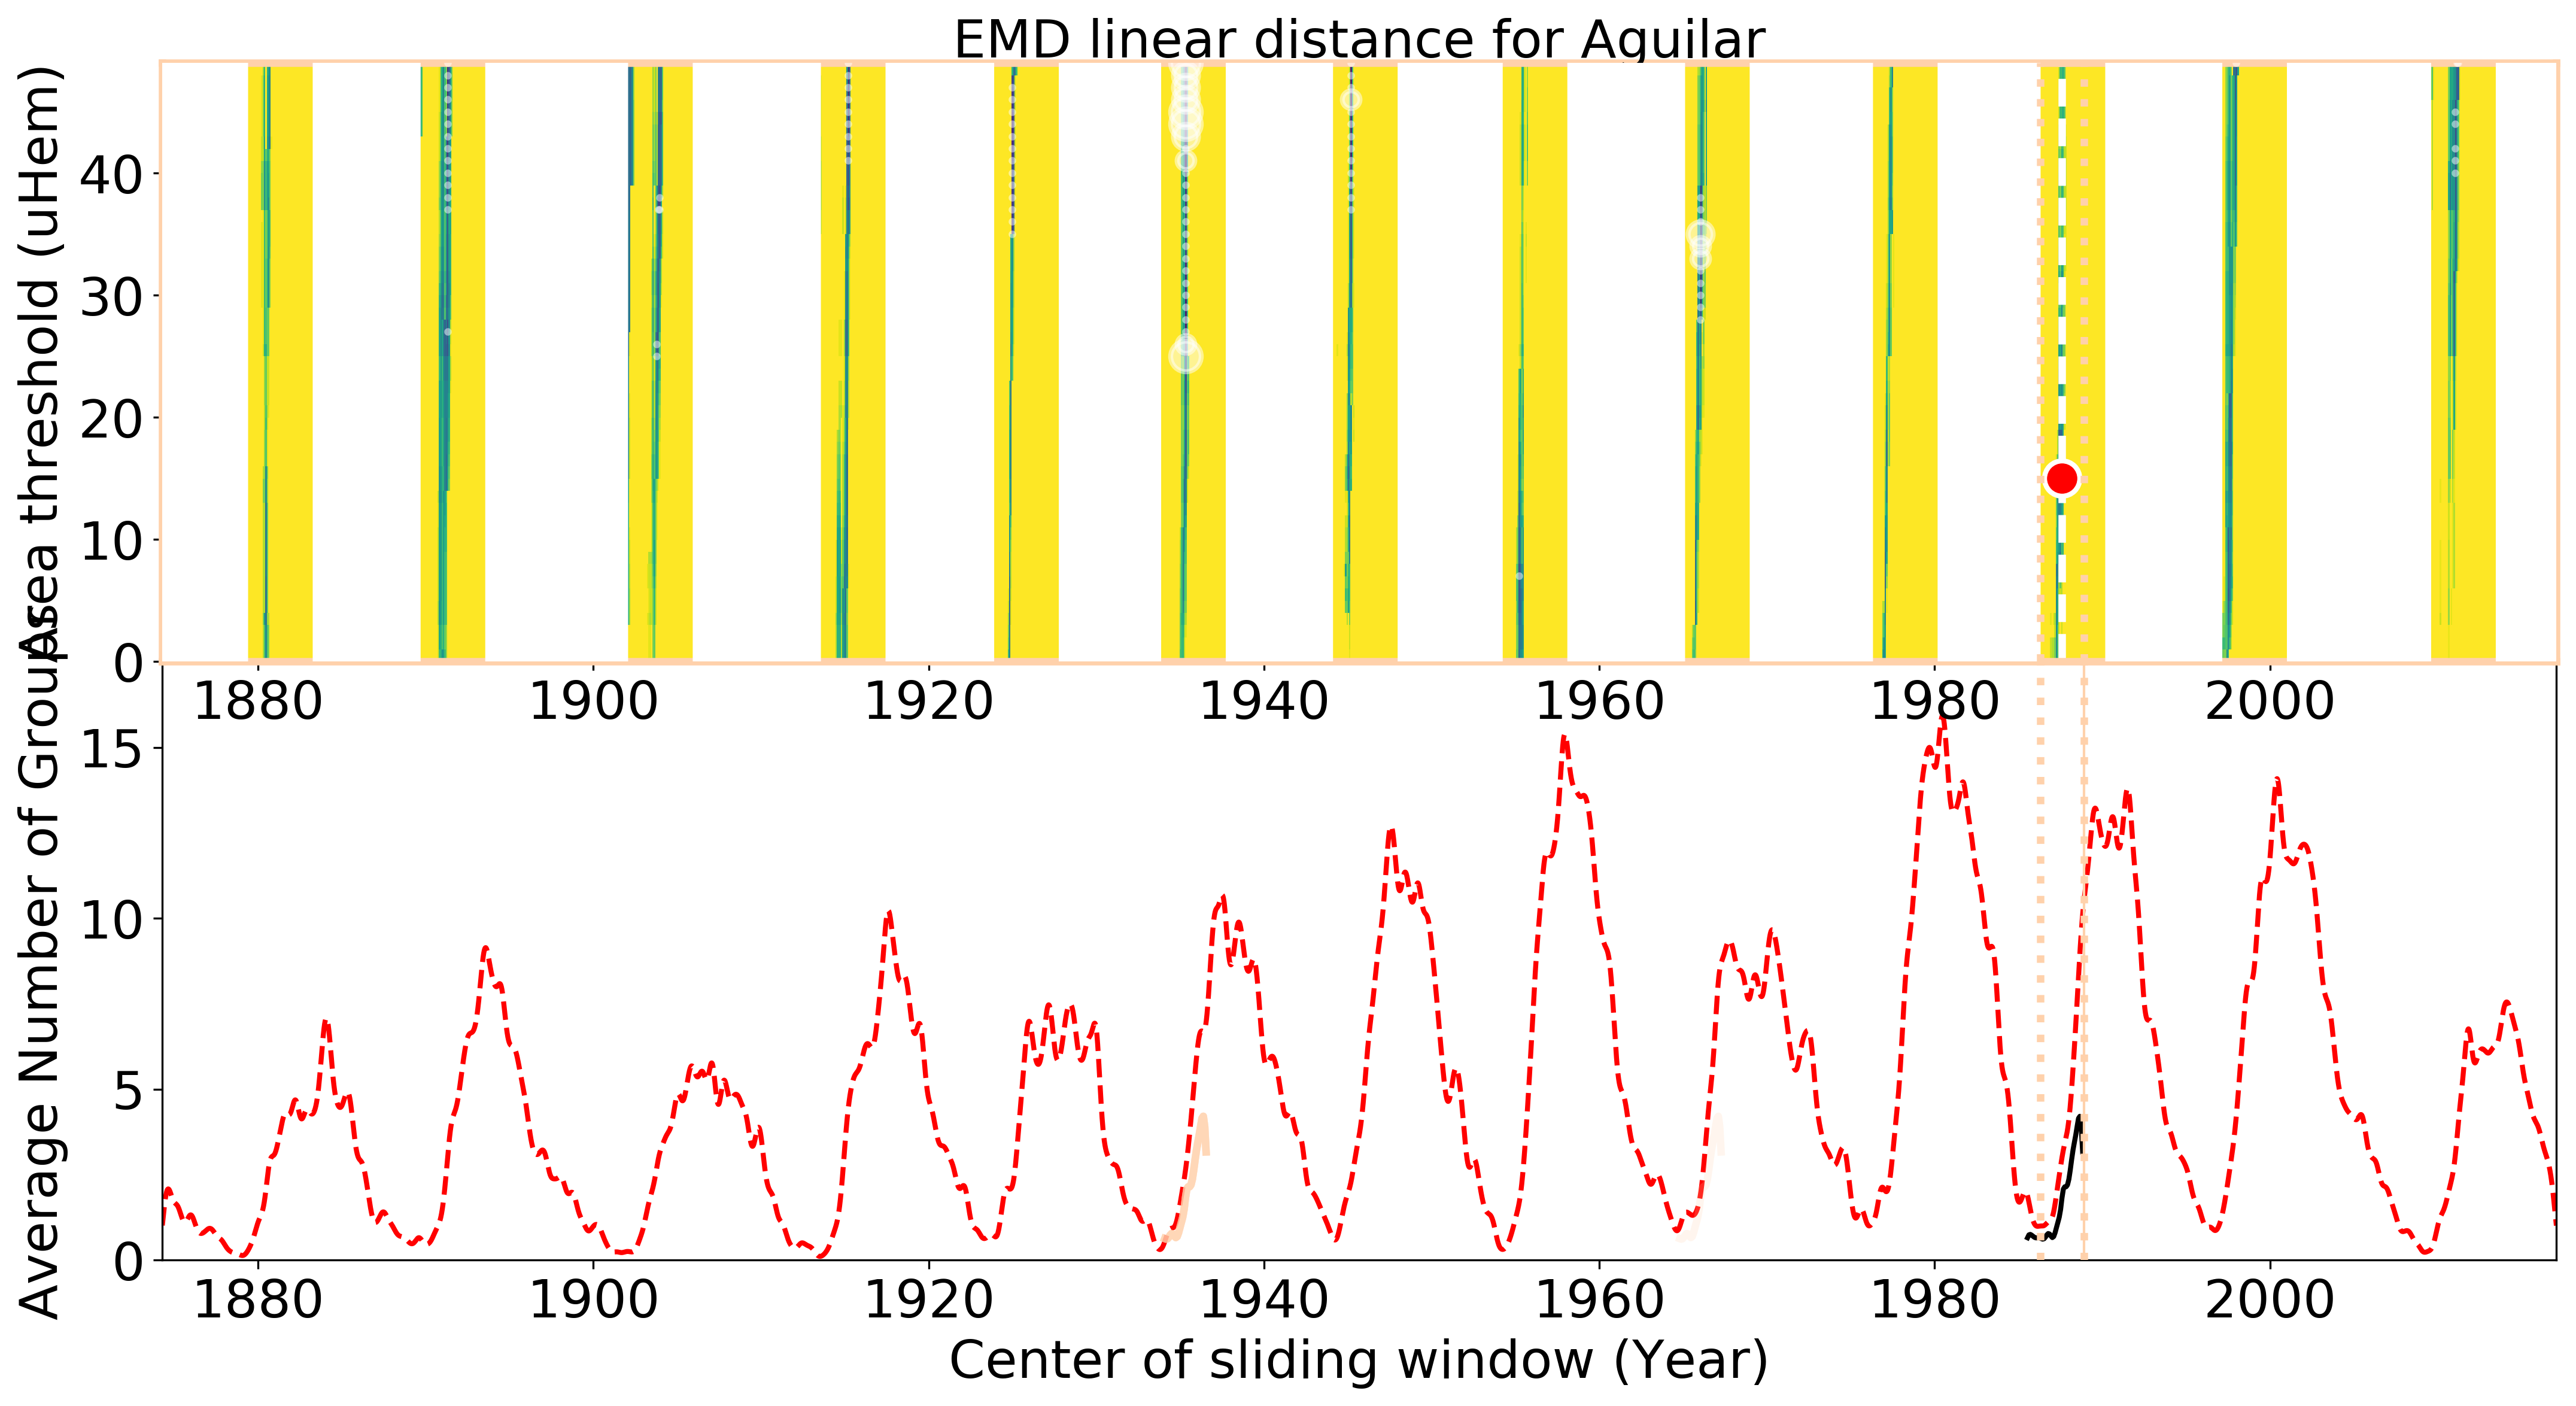

In [73]:
# Low-medium-high activity threshold
#lowth=50
#highth=100

# Number of top best matches to keep
nBest = 50

# Creating Storing dictionaries to store best thresholds
bestTh = []

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel

nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels -> length for centerpoints of given observer (3 in this case) + 1

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


pltx = (fyr1Ob+fyr2Ob)/2

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1) # plot RGO series in bottom panel

# Plotting Observer
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2) #plot given observer series in bottom panel


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)

# EMD Pcolor
plt.viridis()

# most of this is the same that one appeared in the previous kernel
# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    # Creating axis
    ax1 = fig.add_axes([ppadh, ppadv + (siInx+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])
    
    # Defining mask based on the interval type (rise or decay)
    if cenPoints[siInx, 1] > 0:
        cadMaskI = risMaskI
        cadMask  = risMaskP
    else:
        cadMaskI = decMaskI
        cadMask  = decMaskP
        
     # Selecting interval
    #number of groups for given observer (separated by subinterval due to previous for)
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
    #print(TObsDat)
    #dates for given observer (separated by subinterval due to previous for)
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'FRACYEAR'].values.copy()
    #print(TObsFYr)
    #ordinals for given observer (separated by subinterval due to previous for)
    TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'ORDINAL'].values.copy()  
            
    TObsSNd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'AVGSNd'].values.copy()    
    
    # Plot Matrix Only if the period is valid
    if vldIntr[siInx]:  
            
        # Creating matrix for sorting and find the best combinations of threshold and shift
        #OpMat gives multiple row with 3 elements each one (EMD date, EMD threshold, EMD)
        OpMat = np.concatenate((EMDtD[siInx].reshape((-1,1)),EMDthD[siInx].reshape((-1,1)),EMDD[siInx].reshape((-1,1))), axis = 1)
        #print(OpMat)
        
        # Sort according to EMD to find the best matches
        # Sort according to EMD to find the best matches
        I = np.argsort(OpMat[:,2],axis = 0)
        OpMat = np.squeeze(OpMat[I,:])
        #print(OpMat)

        # Find index of minimum inside sub-interval
        minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx, 0]))
        obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx, 0])==minYear).nonzero()[0][0] #this is the center of the interval for given observer

        #Initialize varialbes to identify the optimum threshold for the period of overlap
        tmpEMD = 1e16
        tmpt   = np.nan
        tmpth  = np.nan 

        # Calculate optimum threshold for real period of overlap if it exists    
        # Check if real if interval is present in Observations
        # given observer data has overlap with RGO data (for each subinterval of the given observer data)? -> True or False
        if (TObsFYr[obsMinInx] > np.min(REF_Dat['FRACYEAR'])) and (TObsFYr[obsMinInx] < np.max(REF_Dat['FRACYEAR'])): 
            #print(TObsFYr[obsMinInx] > np.min(REF_Dat['FRACYEAR']))

            # Check if first element is present in reference
            # first ordinal for given observer data is equal to some ordinal in RGO data? -> True or False
            if np.any(REF_Dat['ORDINAL']==TObsOrd[0]):
                
                print('hello')

                # Selecting the maximum integer amount of "months" out of the original data
                TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
                
                
                print('hello')
                
                TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy() ##TObsDat are (daily) sunspot number values from an endpoint to next endpoint for given observer

                #Calculating bracketing indices
                Idx1 =  (REF_Dat['ORDINAL']==TObsOrd[0]).nonzero()[0][0]
                Idx2 = Idx1 + TgrpsOb.shape[0]
                
                TSNdREF = REF_Grp['AVGSNd'][Idx1:Idx2].values.copy()
                TSNdREF = TSNdREF.reshape((-1,MoLngt))
                #print(TSNdREF)
                
                # Going through different thresholds
                for TIdx in range(0,thN):
                #for TIdx in range(0,2):

                    # Calculating number of groups in reference data for given threshold
                    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thI) ,axis = 1).astype(float)
                    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan   
                    
            
                    #defining low and high solar activity level
                    #print(thI)
                    #print(TIdx*thI)
                    highth=0.18*TIdx*thI+31.8
                    print(highth)
                    if TIdx*thI>=60: 
                        lowth = 0.19333333*TIdx*thI-2.66666667
                    else:
                        lowth = 0
                    print(lowth)

                    # Selecting the maximum integer amount of "months" out of the original data
                    TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
                    
                    TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

                    #Selecting reference window of matching size to observer sub-interval;
                    TgrpsREF = grpsREFw[Idx1:Idx2].copy()                

                    # Reshaping into "months"
                    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            
                    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))
                    
                    TObsSNd = TObsSNd.reshape((-1,MoLngt))   #(daily) sunspot number for subinterval using given observer. length = 57 months (30 data per elements)        

                    # Imprinting missing days
                    # OBSERVER
                    TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                    # REFERENCE
                    TgrpsREF[np.isnan(TgrpsOb)] = np.nan

                    # Number of days with groups
                    # OBSERVER
                    GDObsT = np.sum(np.greater(TgrpsOb,0),axis=1)
#                    print(GDObsT)
                    # REFERENCE
                    GDREFT = np.sum(np.greater(TgrpsREF,0),axis=1)

                    # Number of days with observations
                    # OBSERVER
                    ODObsT = np.sum(np.isfinite(TgrpsOb),axis=1)
                    # REFERENCE
                    ODREFT = np.sum(np.isfinite(TgrpsREF),axis=1)
#                    print(ODObsT)
                    
                    # Number of quiet days
                    # OBSERVER
                    QDObsT = ODObsT-GDObsT
                    # REFERENCE
                    QDREFT = ODREFT-GDREFT
#                    print(QDObs[0,0])
                    #print(QDObsT)

                    
                    # monthly (from daily) sunspot number
                    #SNdObs[TIdx,SIdx,:] = np.mean(np.isfinite(TObsSNd),axis=1)
                    #remove "[TIdx,SIdx,:]" for SNdObs and ADFObs/ADFREF and "[TIdx,SIdx]" for the remaining
                    SNdObsT = np.mean(TObsSNd,axis=1)                   
                    SNdREFT = np.mean(TSNdREF,axis=1)
                    #print(SNdObsT[0])
                    #print(SNdREFT[0])
                    
#                    lowval=SNdObs[np.where(SNdObs<50)]
#                    print(lowval)
#                    lowpos=np.where(SNdObs<50)
#                    print(lowpos)
#                    medval=SNdObs[np.where((50<SNdObs) & (SNdObs<100))]
#                    print(medval)
#                    medpos=np.where((50<SNdObs) & (SNdObs<100))
#                    print(medpos)
#                    highval=SNdObs[np.where(SNdObs>=100)]
#                    print(highval)
#                    highpos=np.where(SNdObs>=100)
#                    print(highpos)
                    
#                    print(GDObs[TIdx,SIdx])
#                    print('low activity level')
#                    print(GDObs[TIdx,SIdx][lowpos])
#                    ADFObslT=GDObsT[lowpos]/MoLngt
#                    ADFREFlT=GDREFT[lowpos]/MoLngt
#                    print('medium activity level')
#                    print(GDObs[TIdx,SIdx][medpos])
#                    print(ODObs[TIdx,SIdx][medpos])
#                    ADFObsmT=GDObsT[medpos]/ODObsT[medpos]
#                    ADFREFmT=GDObsT[medpos]/ODREFT[medpos]
#                    print('high activity level')
#                    print(QDObs[TIdx,SIdx][highpos])
#                    ADFObshT=(MoLngt-QDObsT[highpos])/MoLngt
#                    ADFREFhT=(MoLngt-QDREFT[highpos])/MoLngt
                    
#                    ADFObsoldT=np.concatenate([ADFObslT,ADFObsmT,ADFObshT])
#                    ADFREFoldT=np.concatenate([ADFREFlT,ADFREFmT,ADFREFhT])


                    LMObs=SNdObsT<=lowth
                    LMRef=SNdREFT<=lowth
#                    lowval=SNdObs[lowmsk]
#                    print(lowmsk)
#                    print(lowval)
                    MMObs=np.logical_and((lowth<SNdObsT), (SNdObsT<highth))
                    MMRef=np.logical_and((lowth<SNdREFT), (SNdREFT<highth))
#                    medval=SNdObs[medmsk]
#                    medval=SNdObs[TIdx,SIdx][np.where((50<SNdObs[TIdx,SIdx]) & (SNdObs[TIdx,SIdx]<100))]
#                    print(medmsk)
#                    print(medval)
                    HMObs=(SNdObsT>=highth)
                    HMRef=(SNdREFT>=highth)
                    #highval=SNdObs[TIdx,SIdx][np.where(SNdObs[TIdx,SIdx]>=100)]
#                    print(highval)
                    
#                    print(highpos)
                    
#                    print(GDObs[TIdx,SIdx])
#                    print('low activity level')
#                    print(GDObs[TIdx,SIdx][lowpos])
                    ADFObs=GDObsT/MoLngt
                    ADFREF=GDREFT/MoLngt
#                    print('medium activity level')
#                    print(GDObs[TIdx,SIdx][medpos])
#                    print(ODObs[TIdx,SIdx][medpos])
                    ADFObs[MMObs]=GDObsT[MMObs]/ODObsT[MMObs]
                    ADFREF[MMRef]=GDObsT[MMRef]/ODREFT[MMRef]
#                    print('high activity level')
#                    print(QDObs[TIdx,SIdx][highpos])
                    ADFObs[HMObs]=(MoLngt-QDObsT[HMObs])/MoLngt
                    ADFREF[HMRef]=(MoLngt-QDREFT[HMRef])/MoLngt
        
                    #print(ADFObslT)
                    #print(ADFObsmT)
                    #print(ADFObshT)
        
                    #ADFObsT=np.concatenate([ADFObslT,ADFObsmT,ADFObshT])
                    #ADFREFT=np.concatenate([ADFREFlT,ADFREFmT,ADFREFhT])
                    
                    #ADFObsT = ADFObsoldT[np.isfinite(ADFObsoldT)]
                    #ADFREFT = ADFREFoldT
                    #print(ADFObsT)
              

                    # Calculating Earth Mover's Distance
#                    ADFObs, bins = np.histogram(np.divide(
#                        GDObsT[ODObsT/MoLngt>=minObD],
#                        ODObsT[ODObsT/MoLngt>=minObD]),
#                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
#                    ADFREF, bins = np.histogram(np.divide(
#                        GDREFT[ODREFT/MoLngt>=minObD],
#                        ODREFT[ODREFT/MoLngt>=minObD]),
#                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
                    #prueba=(np.arange(0,MoLngt+2)-0.5)/MoLngt
                    #print(prueba)
                    #prueba2=np.isfinite(prueba)
                    #print(prueba2)
                    
                    # Calculating Earth Mover's Distance
                    ADFObsDis, bins = np.histogram(
                        ADFObs[ODObsT/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
                        
                    ADFREFDis, bins = np.histogram(
                        ADFREF[ODREFT/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)   
                                       
                
                    tmp = emd(ADFREFDis.astype(np.float64),ADFObsDis.astype(np.float64),Dis.astype(np.float64))

#                     #Calculating Chi-Square distance
#                     ADFObs, bins = np.histogram(GDObsT[ODObsT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)
#                     ADFREF, bins = np.histogram(GDREFT[ODREFT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)

#                     # Calculating numerator and denominator for Chi-square distance
#                     Nom = np.power(ADFObs-ADFREF,2)
#                     #Den = np.power(ADFObs,2) + np.power(ADFREF,2)
#                     Den = ADFObs + ADFREF

#                     # Removing zeros in denominator
#                     Nom = Nom[Den!=0]
#                     Den = Den[Den!=0]

#                     # Calculating Chi-square distance
#                     tmp = np.sum(np.divide(Nom,Den))

                    # Udating variables
                    if tmp<tmpEMD:
                        tmpEMD = tmp
                        tmpt   = TObsFYr[obsMinInx]
                        tmpth  = TIdx*thI


        OpMat = np.insert(OpMat,0,[tmpt,tmpth,tmpEMD],axis=0)            
            
        # Calculating mesh for plotting
        x = REF_Grp['FRACYEAR'].values[cadMaskI]
        y = np.arange(0,thN)*thI
        xx, yy = np.meshgrid(x, y)             

        #Plotting Optimization Matrix
        # to plot mesh with yellow and blue colors for the three first panels
        mesh = ax1.pcolormesh(xx,yy,EMDD[siInx], alpha = 1, linewidth = 2, vmin = np.min(EMDD[siInx]), vmax = 6*np.min(EMDD[siInx]))

            
        # True Interval
        #plot red dot corresponding to true interval
        ax1.scatter(OpMat[0,0], OpMat[0,1], c = 'r', edgecolors = 'w',linewidths = 2, s = 200, zorder=11)

        # Best 5 points
        for i in range(1,5):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 150, zorder=11, alpha = 0.5)
            ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx, 0]+OpMat[i,0]
                     , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                     , alpha = 0.2)

        # Best 5-10 points
        for i in range(5,10):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 100, zorder=11, alpha = 0.5)
            ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx, 0]+OpMat[i,0]
                     , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                     , alpha = 0.2)

        # Best 10-15 points
        for i in range(10,15):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 50, zorder=11, alpha = 0.5)

        # Best 15-20 points
        for i in range(15,100):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 1, zorder=11, alpha = 0.5)
            
        # Masking Gaps
        pltMsk  = np.logical_not(cadMask)
        ax1.fill_between(REF_Grp['FRACYEAR'],  REF_Grp['FRACYEAR']*0, y2=REF_Grp['FRACYEAR']*0+thN, where=pltMsk, color = 'w', zorder=10)

        # Adding best points
        bestTh.append(OpMat[1:nBest,:])
    
    # If period not valid store an empty array
    else:
        bestTh.append([])

    print('hello')
    # Plotting real location
    ax1.plot(np.array([1,1])*TObsFYr[obsMinInx], np.array([0,np.max(y)]),'w--', linewidth = 3)
    
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])            
            
    # Axes properties
    ax1.set_ylabel('Area threshold (uHem)')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = 0, top = np.max(y))
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

fig.savefig(NamObs.capitalize() + '_EMD_1.png', bbox_inches='tight', dpi = 103, pad_inches=0)

In [74]:
print(TObsSNd)
print(QDObsT)
print(SNdREFT)
print(SNdObsT)
np.sum(SNdObsT - SNdREF)

[[ 26.67387919  26.68750159  26.70136743  26.71547407  26.72981808
   26.74439572  26.75919603  26.77421703  26.78946797  26.80496068
   26.82068574  26.83667263  26.85289225  26.86935162  26.8860688
   26.90300778  26.92018827  26.93760499  26.95527287  26.97317905
   26.99133769  27.00974083  27.02841204  27.04732044  27.06646149
   27.08584165  27.10547404  27.12535997  27.14549155  27.16586028]
 [ 27.18647635  27.20733534  27.22842996  27.24977769  27.27137912
   27.29321737  27.31530692  27.33762818  27.36020676  27.3830115
   27.40605071  27.42934537  27.4528825   27.47668438  27.50071787
   27.52501011  27.5495457   27.57431505  27.59932384  27.62457961
   27.65008737  27.67585215  27.70186373  27.72811256  27.7546025
   27.78135858  27.808372    27.83563353  27.86315101  27.89092462]
 [ 27.91893919  27.94720551  27.97571945  28.00447677  28.03348163
   28.06273097  28.09222568  28.12199654  28.15201888  28.18231807
   28.21287284  28.24370996  28.27482778  28.30622526  28.33788

-669.24890521991

FIGURE: Bottom: Reference average number of groups (red). True location of the observer groups (black). Observer sub-intervals (vertical dotted lines). Top-ten shifts with the best match between observer and reference ADFs (faint colored curves). Each sub-interval is color coded.

Top panels: Each panel shows the distance measured between observer and reference ADFs as a function of threshold and shift for a given sub-interval. The true location of the sub-interval is shown using colored vertical dotted lines. The true shift is indicated by a vertical white dashed line. The optimal threshold for the true interval is shown with a red dot. The best 20 points are denoted by white circles (the smaller the distance, the larger the dot). In the colormap, dark blue denotes a good match and bright yellow a bad match. The color-scale is saturated at 6 times the minimum ADF distance. Invalid intervals are blank.

## Plotting distribution of Thresholds for each interval¶

C:\Users\usuario\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\usuario\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


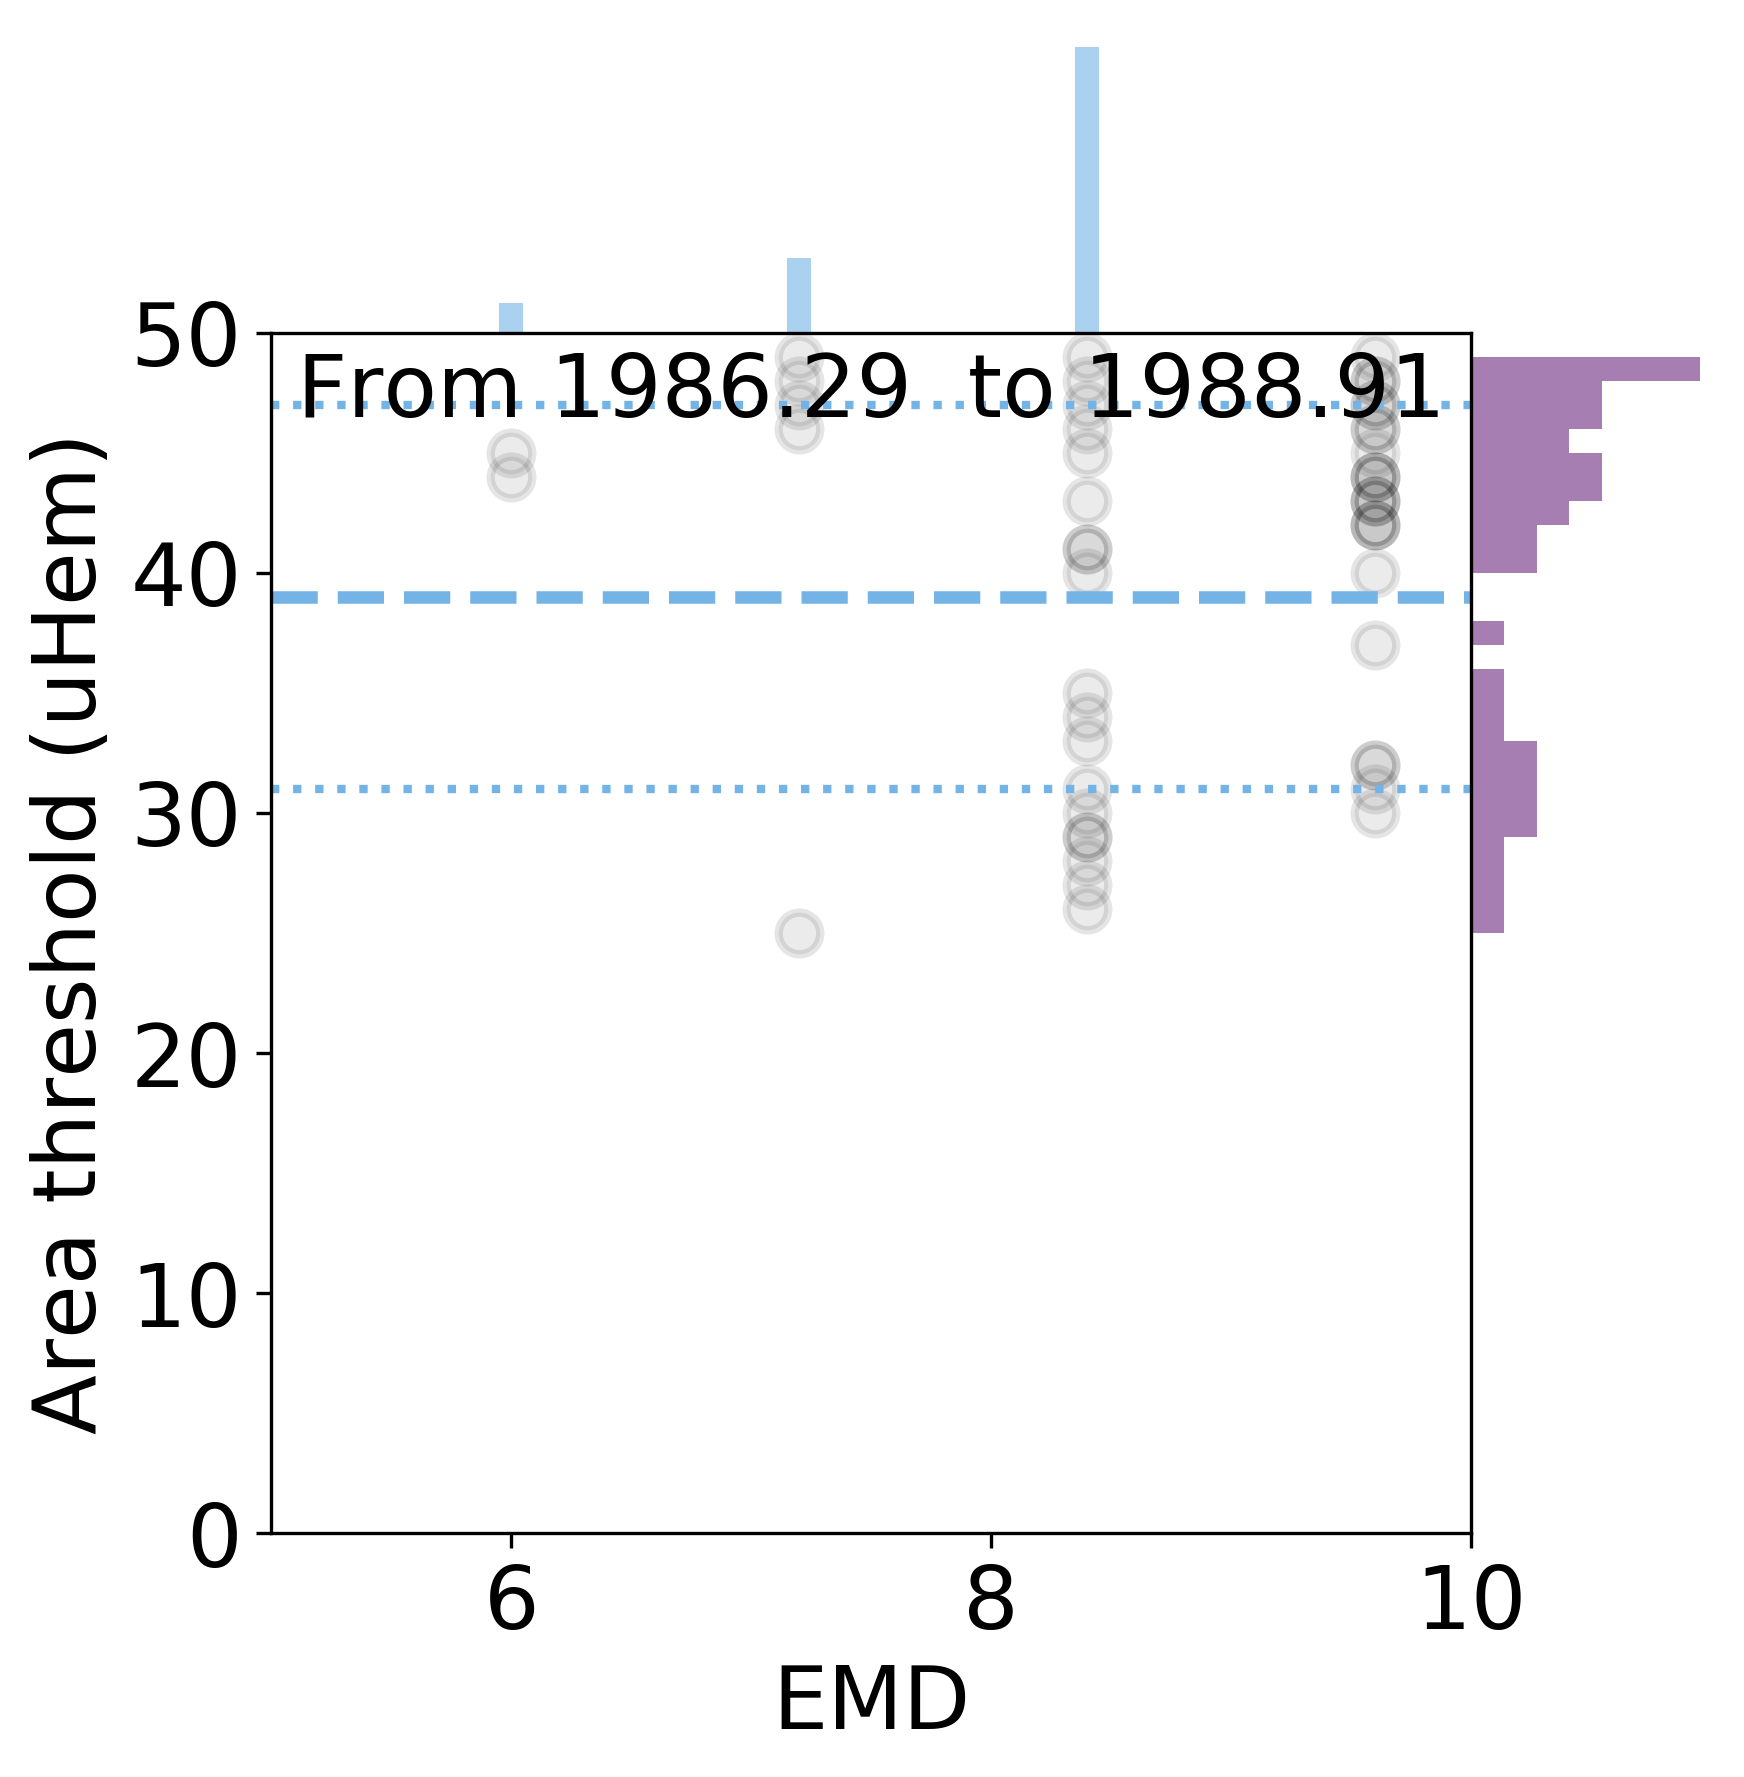

In [75]:
# Variables to store the mean threshold and its standard deviation
wAvI = vldIntr.copy()*0
wSDI = wAvI.copy()

# Distribution Plots of EMD thresholds for different intervals
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels # because we have 3 subintervals
npv = int(np.ceil(vldIntr.shape[0]/nph))      # Number of vertical panels #number of valid interval divided by number of horizontal panels (for Moye case is equal to 1)

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 100  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 100 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
for i in range(0, nph):
    for j in range(0,npv):
                
        n = (nph*(j)+i)
        
        #Only add the panel if it exists 
        if n<vldIntr.shape[0]:

            # Plot only if the period is valid
            if vldIntr[n]:
                
                # bestTh[n]) is a list with elements [date, threshold, EMD] for each subinterval sorted by best EMD (from lower to higher)
                # bestTh[n][:,2] is for column 2 that it is EMD values
                # Top Distribution
                axd = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) , ppadv + j*(pxy/fszv+ppadv2) + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)], label= 'a'+str(n))
                axd.hist(bestTh[n][:,2], bins= (np.arange(0,42)-0.5)/nBest*(np.ceil(np.max(bestTh[n][:,2]))-np.floor(np.min(bestTh[n][:,2])))
                         +np.floor(np.min(bestTh[n][:,2])),  color=Clr[4], alpha=.6, normed = True);

                # Axes properties
                axd.set_xlim(left = np.floor(np.min(bestTh[n][:,2])), right = np.ceil(np.max(bestTh[n][:,2])))
                axd.set_axis_off()


                # Right Distribution
                ax2 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) + pxx/fszh*frc, ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc*(1-frc), pxy/fszv*frc], label= 'b'+str(n))
                ax2.hist(bestTh[n][:,1], bins = np.arange(0,thN,thN/nBest)*thI,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);

                # # Axes properties
                ax2.set_ylim(bottom = 0, top = thN*thI)
                ax2.set_axis_off()

                # Scatter Plot
                ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], sharex=axd, label= 'b'+str(n))
                ax1.scatter(bestTh[n][:,2], bestTh[n][:,1], color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)

                # Constructing weights
                alph = 1-(bestTh[n][:,2]-np.min(bestTh[n][:,2]))/(np.max(bestTh[n][:,2])-np.min(bestTh[n][:,2]))

                # Weighted average
                wAvI[n] = np.sum(np.multiply(alph,bestTh[n][:,1]))/np.sum(alph)

                # Weighted Standard Deviation
                wSDI[n] = np.sqrt(np.sum(np.multiply(alph,np.power(bestTh[n][:,1]-wAvI[n],2)))/np.sum(alph))

                ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n], '--'
                         , color = Clr[4], linewidth = 3)
                ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n]-wSDI[n], ':'
                         , color = Clr[4], linewidth = 2)
                ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n]+wSDI[n], ':'
                         , color = Clr[4], linewidth = 2)

                # Axes properties
                ax1.set_ylabel('Area threshold (uHem)')
                ax1.set_xlabel('EMD')
                ax1.text(0.5, 0.95,'From ' + str(np.round(endPoints[n, 0],decimals=2)) + '  to ' + str(np.round(endPoints[n+1, 0],decimals=2)) , horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)
                ax1.set_xlim(left = np.floor(np.min(bestTh[n][:,2])), right = np.ceil(np.max(bestTh[n][:,2])))
                ax1.set_ylim(bottom = 0, top = thN*thI);

FIGURE: Each panel shows a scatterplot of the optimal EMD distance vs. optimal thresholds, as well as their marginal distributions for each valid interval separately. The thick blue line shows the average threshold weighted by distance and the thin blue lines show its weighted standard deviation. Invalid intervals are blank.


## Scatterplot of Overlapping Reference and Calibrated days using only days during valid intervals

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


[1.15079365 1.36254682 1.62666667 1.98431373 2.15087719 2.35886525
 2.58373984 2.7037037  2.87368421        nan        nan]
[0.00604434 0.0237658  0.07022222 0.08210688 0.0743121  0.10185403
 0.06954591 0.02282579 0.04018467        nan        nan]


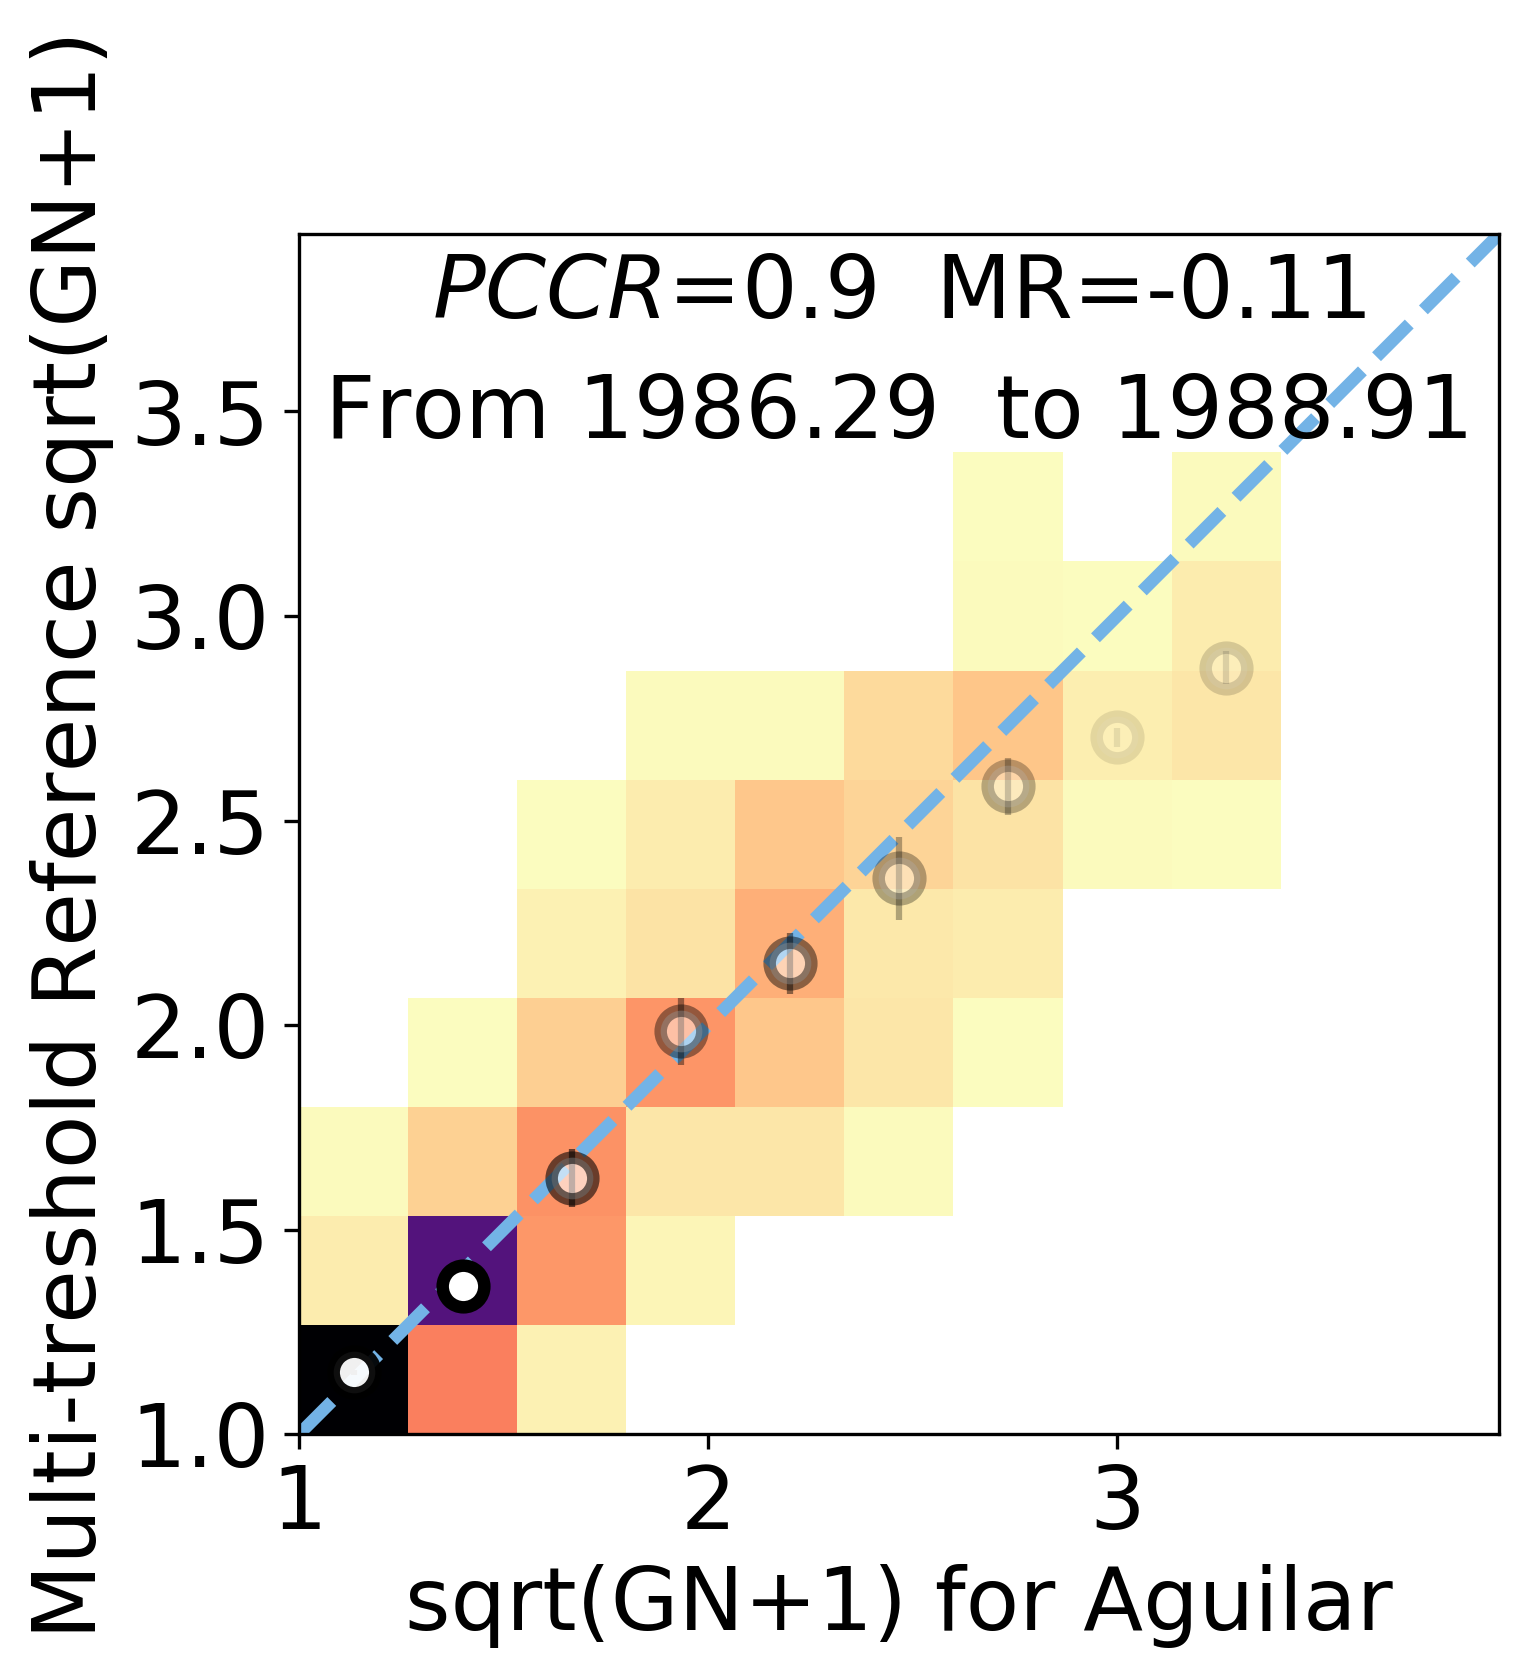

In [76]:
calRef = np.array([0])
calObs = np.array([0])


# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels        # because we have 3 subintervals
npv = int(np.ceil(vldIntr.shape[0]/nph))      # Number of vertical panels        #number of valid interval divided by number of horizontal panels (for Moye case is equal to 1)

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 100  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 100 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
for i in range(0, nph):
    for j in range(0,npv):
                
        n = (nph*(j)+i)
        
        #Only add the panel if it exists 
        if n<vldIntr.shape[0]:

            # Plot only if the period is valid and has overlap
            if vldIntr[n] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[n, 0],REF_Dat['FRACYEAR']<endPoints[n+1, 0]))>0:
                
                #wAvI is the optimal interval for n?
                #print(wAvI[n])
                # Calculating number of groups in reference data for given threshold
                grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAvI[n]) ,axis = 1).astype(float)
                grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

                # Selecting observer's interval
                # in this way, we select the different subintervals
                TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                     ,'GROUPS'].values.copy()
                TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                     ,'ORDINAL'].values.copy()
                
                # now we select days with overlap between both distributions and remove postions with nan values
                # Selecting the days of overlap with calibrated observer
                grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
                grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]
                #print(grpsObsw)
                #print(grpsREFw)

                # Removing NaNs    
                grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
                grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

                grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
                grpsREFw = grpsREFw[np.isfinite(grpsREFw)]
                #nan removed from both distributions; length for both distribution is the same
                #print(grpsObsw)
                #print(grpsREFw)
                # Appending to calibrated arrays?
                calRef = np.append(calRef,grpsREFw)
                calObs = np.append(calObs,grpsObsw)
                #print(calObs[0:15])
                #print(calRef[0:15])
                
                
                maxN = np.sqrt(np.max([np.nanmax(grpsREFw),np.nanmax(TObsDat)])) #sqrt of the max group number of the two observations (in this case, group RGO number is always higher than those for given observer)
                #print(max(grpsREFw))
                #print(max(TObsDat))
                #print(maxN)
                
                # Average group number 
                ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
                # PCCR and MR is defined at the beginning of the notebook in the function: def plotHistSqrtSSN(ax, calRefT, calObsT, maxN):
                plotHistSqrtSSN(ax1, grpsREFw, grpsObsw, maxN)

                #to plot date in the box
                ax1.text(0.5, 0.85,'From ' + str(np.round(endPoints[n, 0],decimals=2)) + '  to ' + str(np.round(endPoints[n+1, 0],decimals=2)) , horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)
                
                # Axes properties
                ax1.set_xlabel('Observed GN for ' + NamObs.capitalize())
                ax1.set_ylabel('Ref. GN with Th. = ' + str(np.round(wAvI[n],decimals=2)))   
                ax1.set_xlabel('sqrt(GN+1) for ' + NamObs.capitalize())
                ax1.set_ylabel('Multi-treshold Reference sqrt(GN+1)')
                
        
# this kernel prints for each subinterval: [meanY] ; [sDY]  -> calculated from function def plotHistSqrtSSS defined at the beginning      


FIGURE: Each panel shows a scatterplot of the Observer vs. the reference after applying the optimal threshold obtained in the step above. Each valid interval is done separately and only if it has overlap with the reference. Behind the scatterplot is show a color 2D histogram showing the number of points in each block. The faint dots also indicate less counts. Invalid intervals are blank.

# Simultaneous Optimization of Thresholds for All Sub-Intervals
The reason behind the division of the observer in sub-intervals is to allow for sequences combining cycles of various strengths that may have been observed outside the reference period, but not in the last 100 years. However, fitting each sub-interval separately suffers from reduced statistics. To address that, we perform simultaneous fits for all sub-interval by specifying a threshold, but letting each sub-interval's shift be freely optimized.


## Calculating the minimum distance for each sub-interval and each shift to identify shifts we could ignore
Using combinations of all possible shifts results in a large, unmanageable, amount of possibilities. For this reason, for each sub-interval we limit the search to their best shifts defined using the minimum distance for each shift including all thresholds and capped at disThres times the best distance for each sub-interval (see below)

Number of valid combinations: 1
[1]


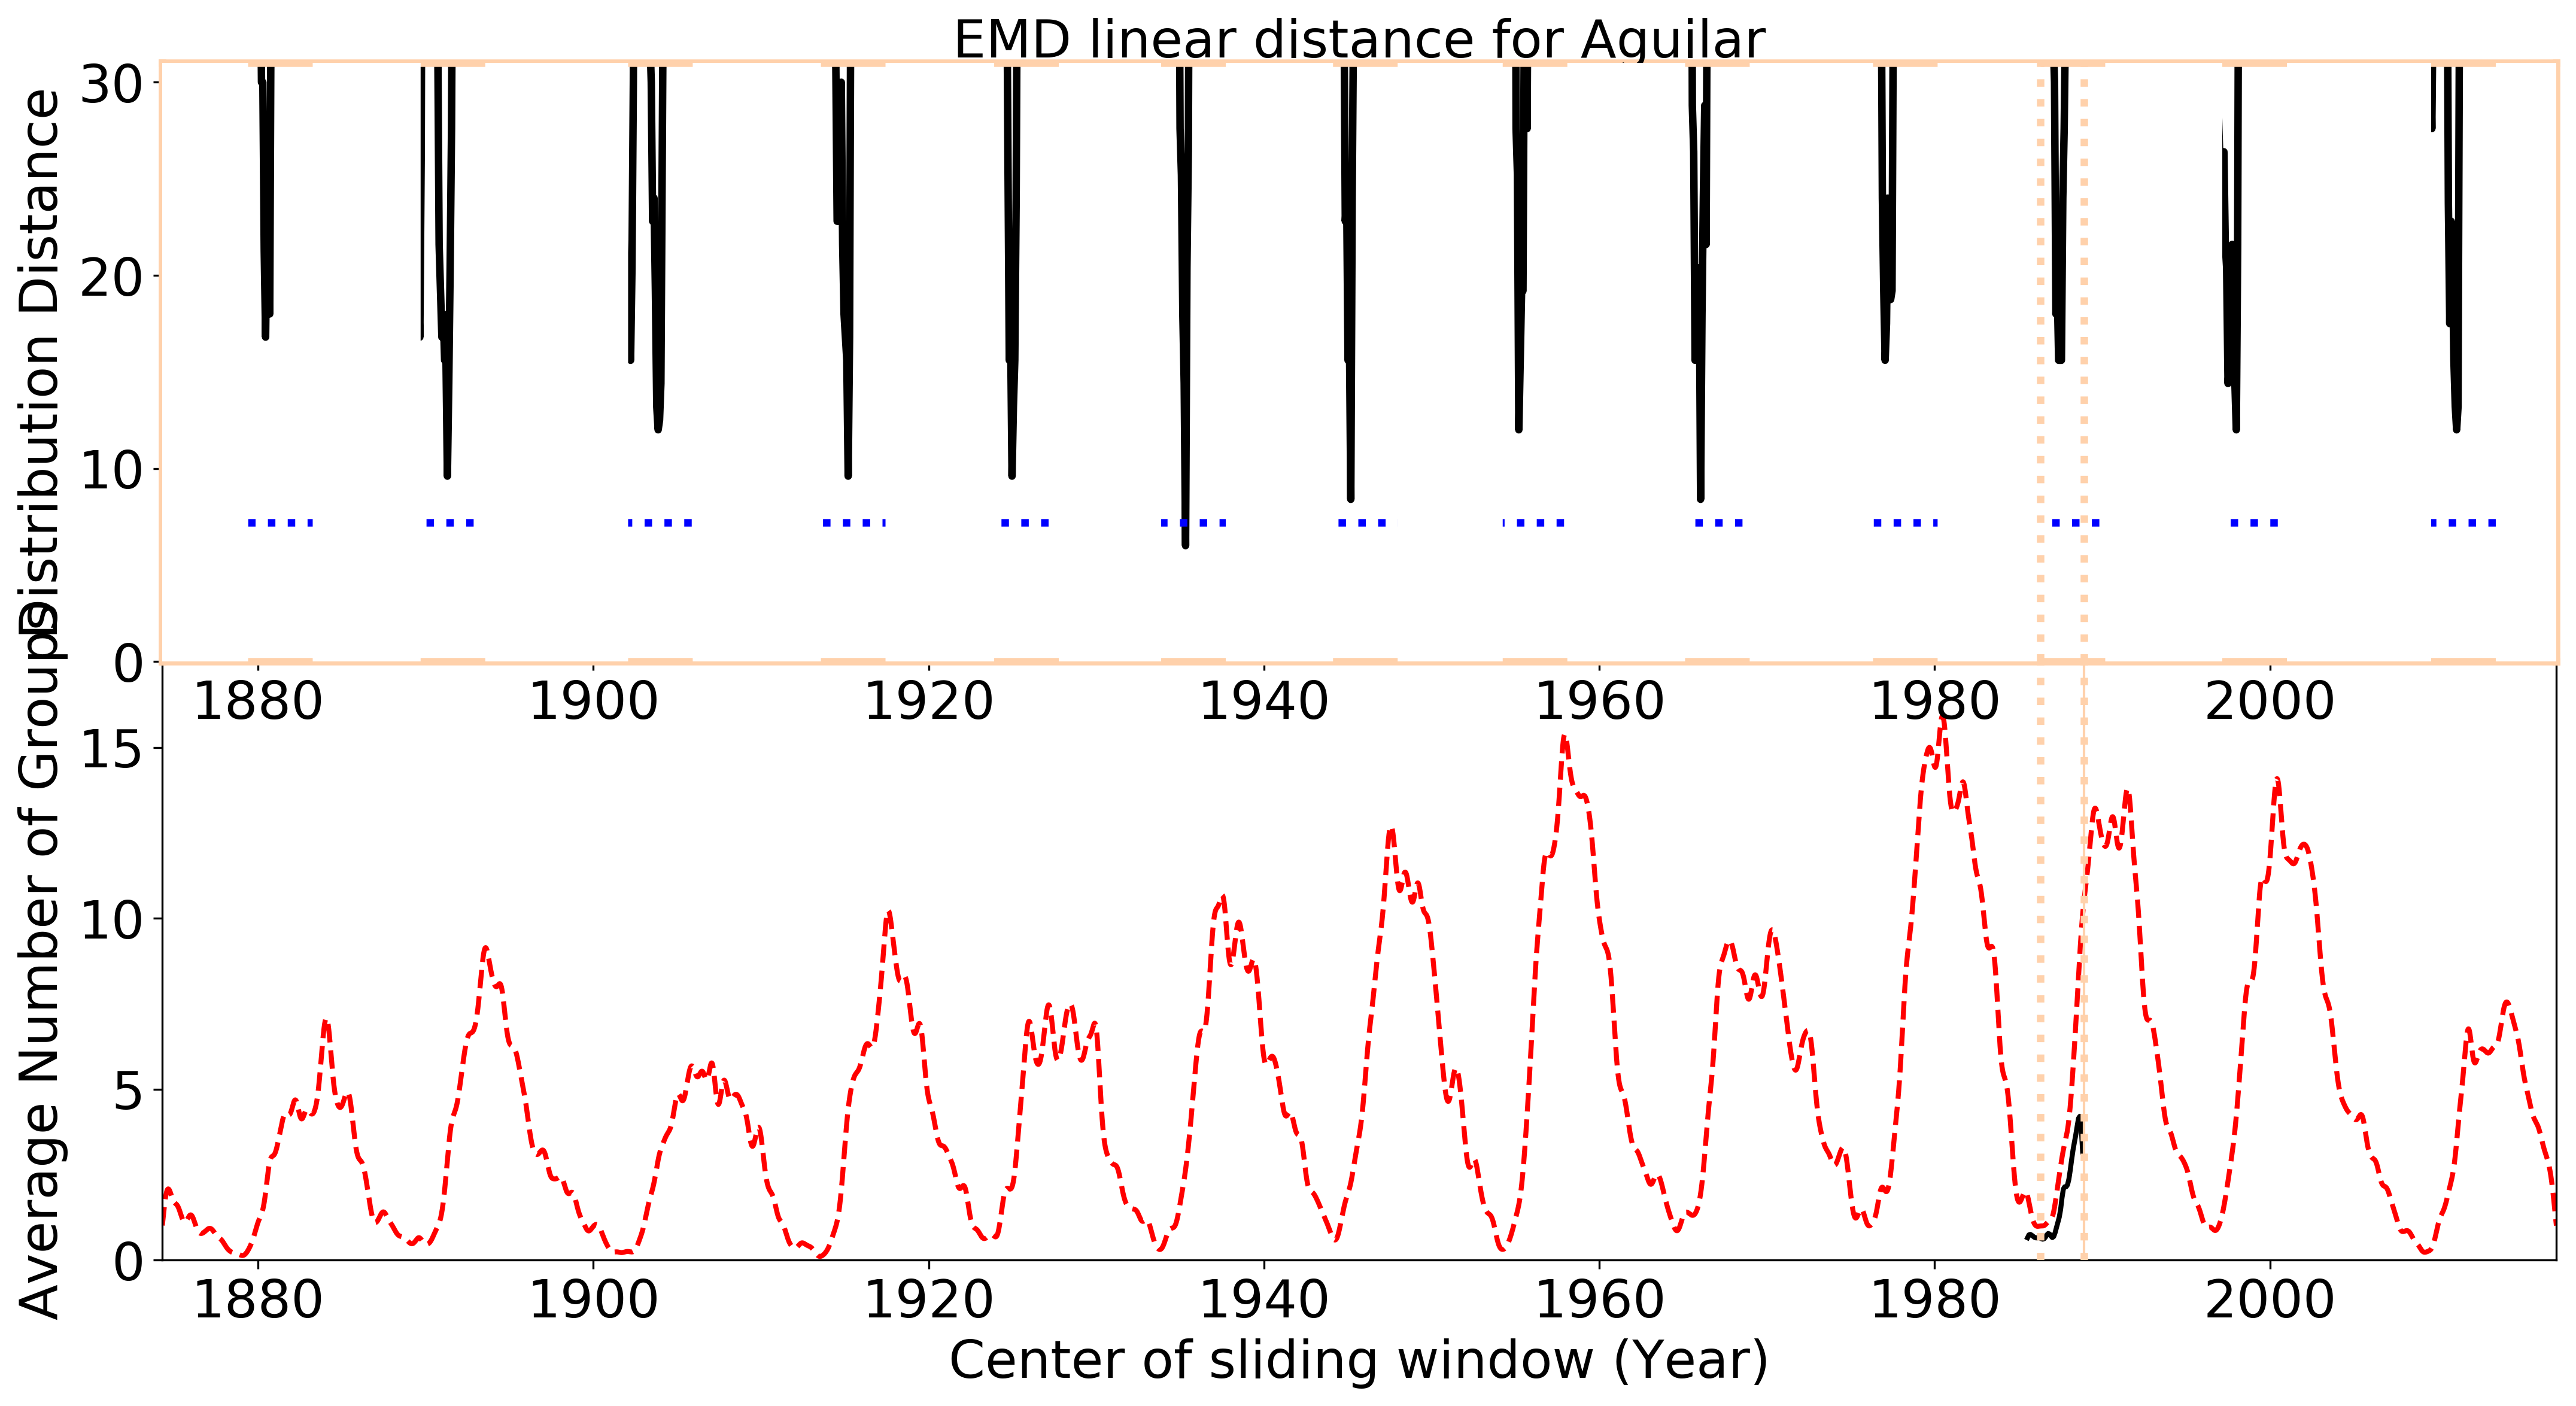

In [77]:
# Threshold above which we will ignore timeshifts (in units of the shortest 
# distance between observer and reference ADFs for each sub-interval separately)
disThres = 1.20

# Dictionary that will store valid shift indices for each sub-interval
valShfInx = []

# Dictionary that will store the length of the index array for each sub-interval
valShfLen = []

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel           


nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels       #number of valid interval divided by number of horizontal panels (for Moye case is equal to 1)

# Padding
padv  = 30 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 30 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
#to plot RGO series in the bottom panel
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
#to plot given observer series in the bottom panel
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2)


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)


# Going through different sub-intervals
# this is similar to previous kernels
for siInx in range(0,cenPoints.shape[0]):
    
    # Defining mask based on the interval type (rise or decay)
    if cenPoints[siInx, 1] > 0:
        cadMaskI = risMaskI
        cadMask  = risMaskP
    else:
        cadMaskI = decMaskI
        cadMask  = decMaskP
        
    # Creating axis
    ax1 = fig.add_axes([ppadh, ppadv + (siInx+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])
    
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx,0],ObsDat['FRACYEAR']<endPoints[siInx+1,0])
                         ,'FRACYEAR'].values.copy()  #dates for given observer (separated by subinterval due to previous for)
    #print(TObsFYr)
        
    # Plot only if period is valid
    if vldIntr[siInx]:           
                
        # Calculating minimum distance for plotting
        x = REF_Grp['FRACYEAR'].values[cadMaskI] #RGO dates according to cadMakI (depend if rising or decline phase)
        #print(x)
        y = np.amin(EMDD[siInx],axis=0) #EMDD values for those dates
        #print(y)
        
        # Appending valid indices to variable and storing length
        #to know the number of valid combination (for each subinterval due to for)
        valShfInx.append((y<=disThres*np.min(y)).nonzero()[0])
        valShfLen.append(valShfInx[siInx].shape[0])

        # Plotting Optimization Matrix
        ax1.plot(x,y, color = 'k', linewidth = 3) #plot EMD series in the three first panels
        
        # Masking Gaps
        #to plot the the blue horizontal dots by interval and not as a continuous line
        pltMsk  = np.logical_not(cadMask)
        ax1.fill_between(REF_Grp['FRACYEAR'],  REF_Grp['FRACYEAR']*0, y2=REF_Grp['FRACYEAR']*0+np.min(y)*10, where=pltMsk, color = 'w', zorder=10)
        
    
        # Plotting possible theshold
        #plot the possible threshold (blue horizontal dots) in the three first panels
        ax1.plot(np.array([np.min(x),np.max(x)]),np.array([1,1])*disThres*np.min(y), 'b:', linewidth = 3)
    
    # If period is not valid append ones so that they don't add to the permutations
    else:
        valShfInx.append(1)
        valShfLen.append(1)
        
    # Plotting edges
    #to plot the vertical lines that delimited the subintervals (rising and decline phase)
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])        
    
    # Axes properties
    ax1.set_ylabel('Distribution Distance')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = 0, top = np.min(y)*5+1)
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

# Saving lengths as array
valShfLen = np.array(valShfLen)

print('Number of valid combinations:', np.nanprod(valShfLen))
print(valShfLen)

FIGURE: Bottom: Reference average number of groups (red). True location of the observer groups (black). Observer sub-intervals (vertical dotted lines).

Top panels: Each panel shows the smallest EMD distance of all possible thresholds for a given window shift. The dotted blue lines indicate the upper threshold used to to determine the possible shifts that will be combined in the simultaneous fit. Invalid intervals are blank.

## Defining Functions to Iterate Over All Possible Combinations

In [78]:
from copy import copy

def mrange(min_values, max_values=None):
    '''
        Inputs: min_values, a list/tuple with the starting values
                    if not given, assumed to be zero
                max_values: a list/tuple with the ending values
        outputs: a tuple of values
    '''
    
    if not max_values:
        max_values = min_values
        min_values = [0 for i in max_values]
    indices_list = copy(min_values)

    #Yield the (0,0, ..,0) value
    yield tuple(indices_list)
    
    while(True):
        indices_list = updateIndices(indices_list, min_values, max_values)
        if indices_list:
            yield tuple(indices_list)
        else:
            break#We're back at the beginning
   
def updateIndices(indices_list, min_values, max_values):
    '''
        Update the list of indices
    '''
    for index in range(len(indices_list)-1, -1, -1):
        
        #If the indices equals the max values, the reset it and 
        #move onto the next value
        if not indices_list[index] == max_values[index] - 1:
            indices_list[index] += 1
            return indices_list
        else:
            indices_list[index] = min_values[index]
    return False

## Doing simultaneous fitting of all intervals by prescribing a common threshold but allowing for any combination of shifts
In order to keep memory requirements manageable we only keep the top nBest matches.

In [79]:
# Allocating variable to store top matches
EMDComb = np.ones((cenPoints.shape[0]+2,nBest))*10000 #cenPoints.shape[0] is the number of subintervals (rising and decline) number for given observer; nBest is the best combination number and was defined as 50

# Identify first valid index
fstVldIn = vldIntr.nonzero()[0][0]

#datetime.datetime.now is the current date and time
print('start', datetime.datetime.now(), '0 of', valShfLen[fstVldIn]-1) #valShfLen=[4 1 1] -> valShfLen[fstVldIn]=4

comProg = 0
for comb in mrange(valShfLen): #valShfLen=[4 1 1]
    
    # Inform user of progress
    if comb[fstVldIn]!=comProg:
        print(comb[fstVldIn], 'of', valShfLen[fstVldIn]-1, 'at', datetime.datetime.now())
        comProg = comb[fstVldIn]        
        
    # Going through different thresholds for a given combination of shifts
    for TIdx in range(0,thN):
        
        # Initializing arrays for joining the ADFs of all sub-intervals
        ADFObsII = np.array([])
        ADFREFII = np.array([])
        
        # Joining ADF from all sub-interval for the specified shifts
        for siInx in range(0,cenPoints.shape[0]):
            
            # Append only if period is valid
            if vldIntr[siInx]: 
            
                # If it is the first interval re-create the arrays
                if ADFObsII.shape[0] == 0:
                    #print(ODObsI[siInx])                    
                    ADFObsII = ADFObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
                    #ADF for given observer for each threshold and subinterval (due to 'for')
                    #GDObsI is the monthly number of days with groups
                    #ODObsI is the monthly number of days with observations
                    
                    ADFREFII = ADFREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
                    #the same for RGO data
                    
                # If not, append ADF from all sub-interval for the specified shifts
                else:                    
                    ADFObsII = np.append(ADFObsII,ADFObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD])
                    
                    ADFREFII = np.append(ADFREFII,ADFREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD])
                    
        # Calculating Earth Mover's Distance
        #EMD from ADF for 50 threshold
        ADFObs, bins = np.histogram(ADFObsII, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        ADFREF, bins = np.histogram(ADFREFII, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        tmpEMD = emd(ADFREF.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64))
        #print(tmpEMD)
        
        #print(EMDComb[0,:])
        #tmpEMD are append to an array (insArr?). This loop read the tmpEMD calculated and it is included in the array if its value is lower than tmpEMD already included in the array
        #note that at the beginning all values included in the array are equal to 10000 and, thus, the first values are all included until reaching the length of the array (=50)
        #moreover, for is for 50? different thresholds and, in the final array, the 50 lowest tmpEMD values remains in the array (independently of the threshold value)
        if np.any(EMDComb[0,:]>tmpEMD):
            
            # Determining index for insertion
            insInx = nBest-np.sum(EMDComb[0,:]>=tmpEMD)
            
            # Initializing array to be inserted
            insArr = [tmpEMD,TIdx]
            
            # Append shifts
            for siInx in range(0,cenPoints.shape[0]):
                
                # Append only if period is valid
                if vldIntr[siInx]:                
                    insArr.append(valShfInx[siInx][comb[siInx]])
                # If not, append dummy    
                else:
                    insArr.append(np.nan)
            
            # Convert to numpy array
            insArr = np.array(insArr)
            
            # Insert values
            EMDComb = np.insert(EMDComb, insInx, insArr, axis=1)
            
            # Remove last element
            EMDComb = EMDComb[:,0:nBest]
            

start 2018-09-19 19:43:44.770362 0 of 0


## Plot Location and Threshold of Best Matches

C:\Users\usuario\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


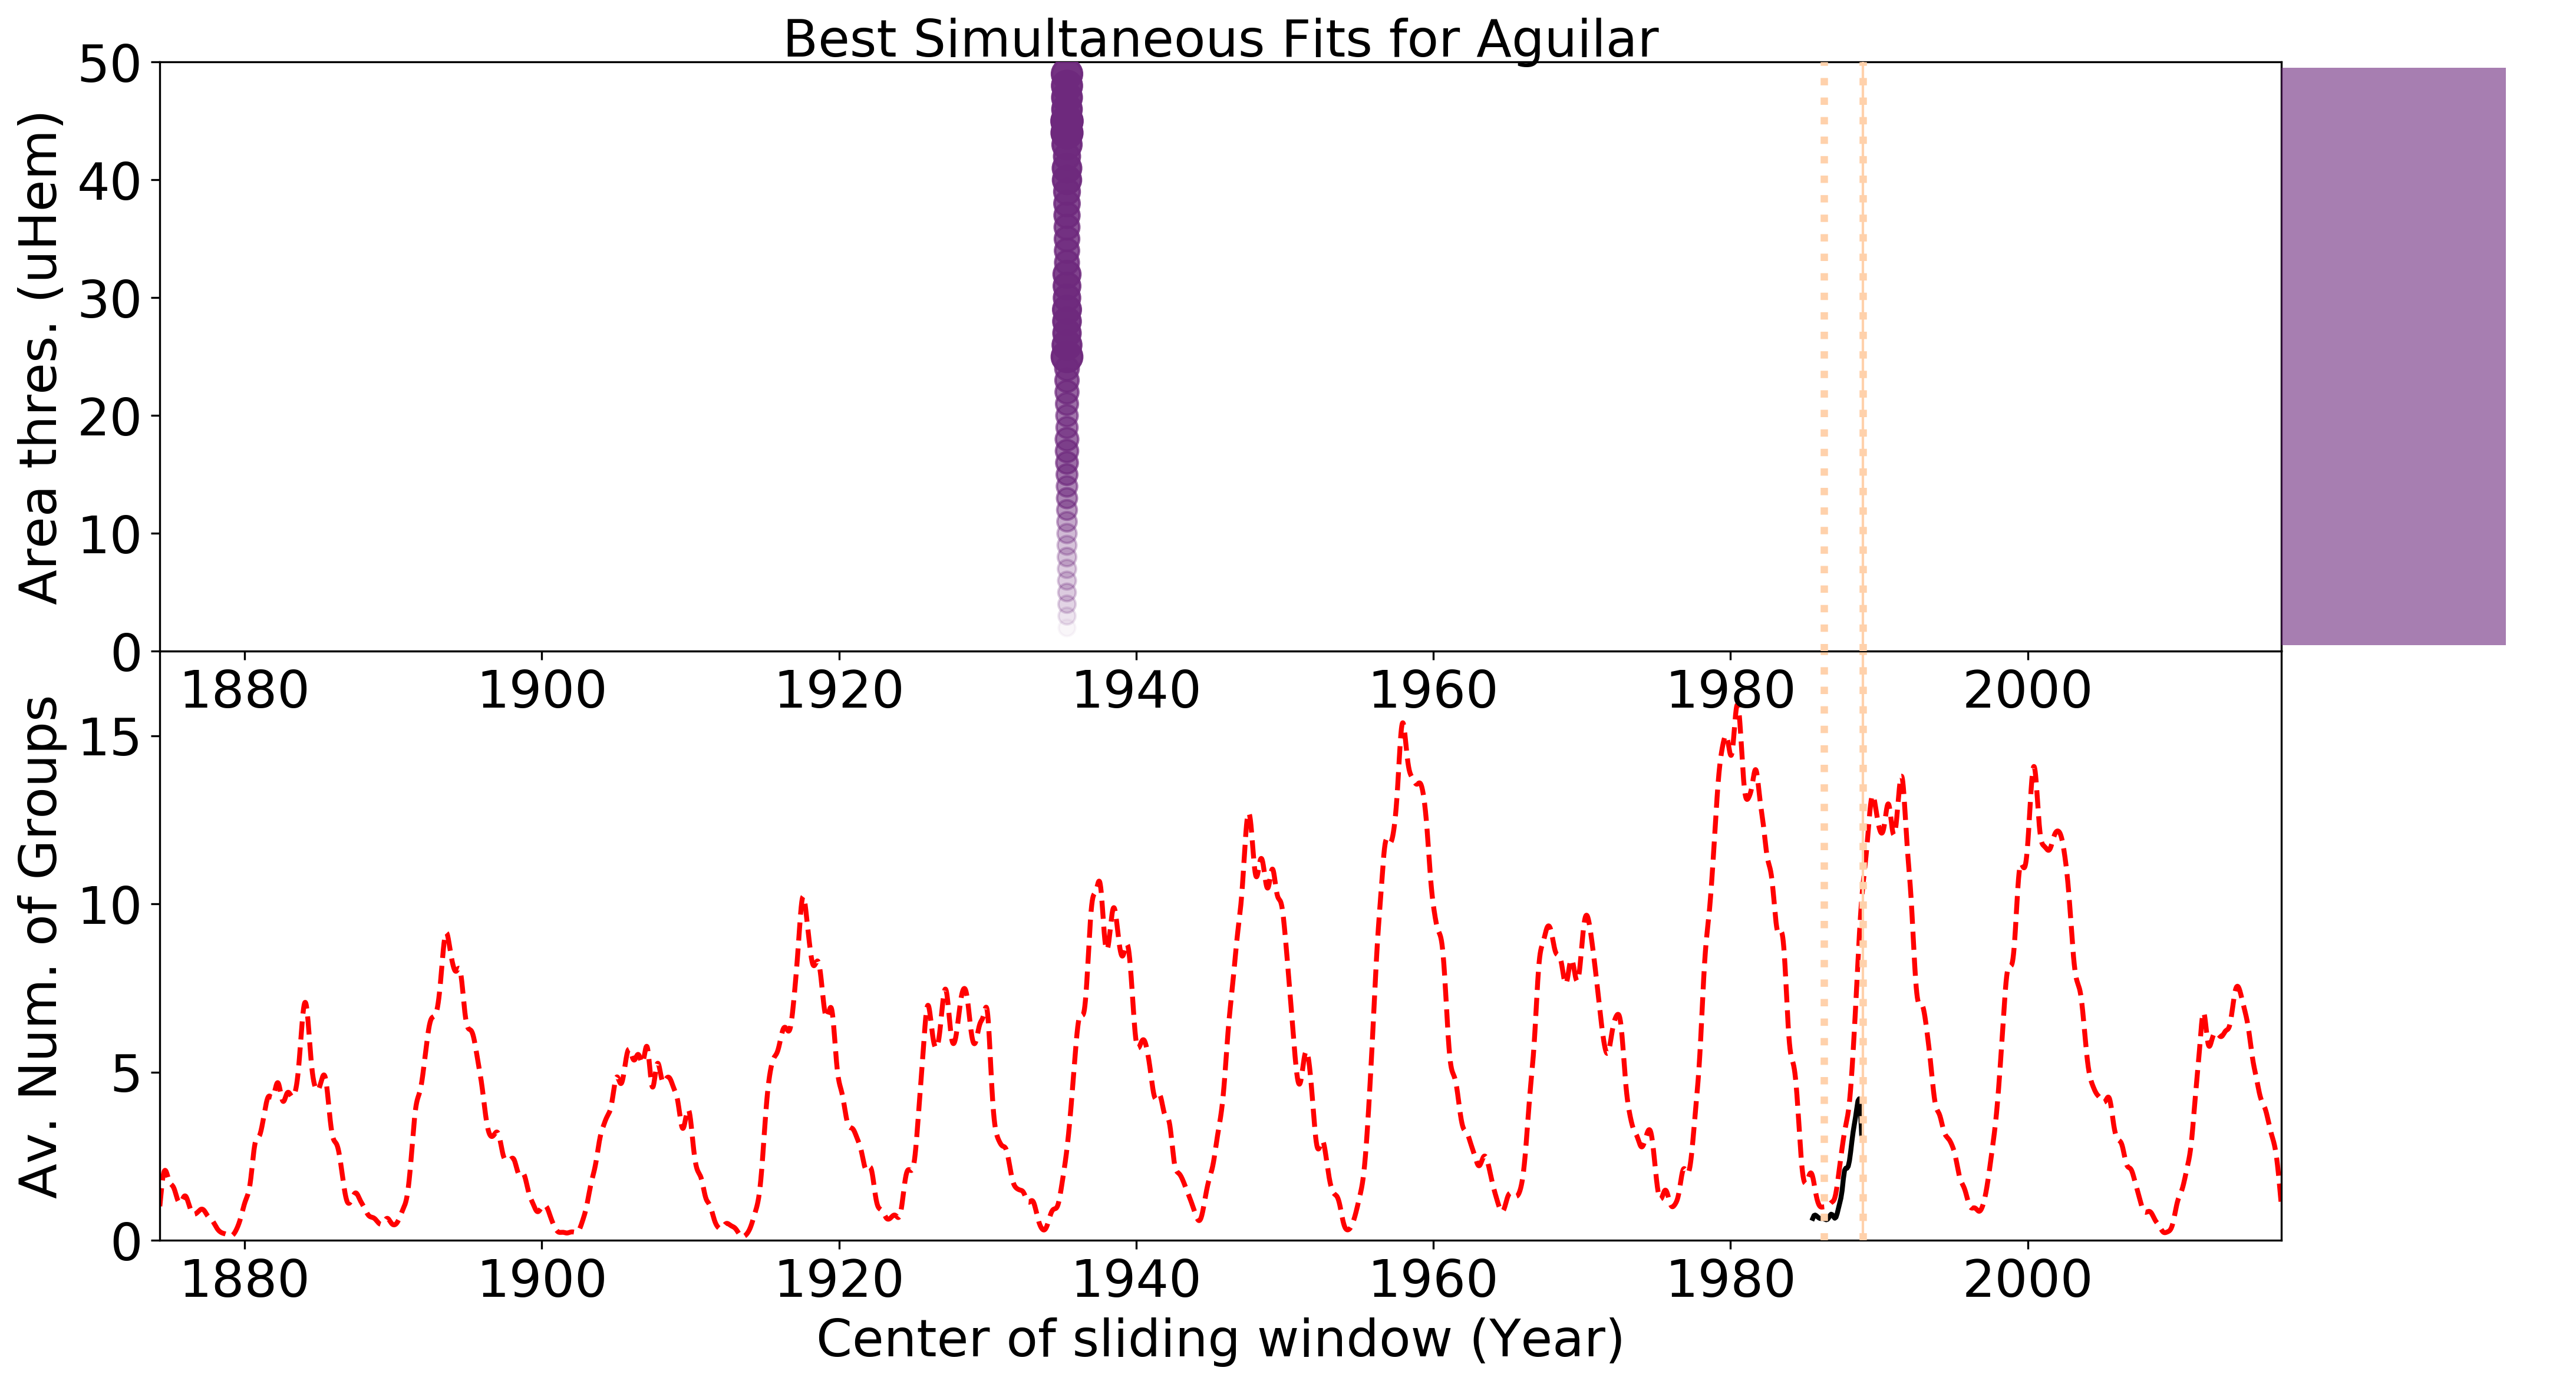

In [80]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000   # Vertical size of each panel
frc = 0.9    # Fraction of the panel devoted to histogram

nph = 1    # Number of horizontal panels
npv = 2    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1) #plot group RGO series

# Plotting Observer
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2) #plot group given observer series

# Axes properties
ax2.set_ylabel('Av. Num. of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)


# Placement of top simultaneous fits
ax1 = fig.add_axes([ppadh, ppadv + (pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv])


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx,0],ObsDat['FRACYEAR']<endPoints[siInx+1,0])
                         ,'FRACYEAR'].values.copy() #dates for each subintervals (rising and decline)       
   
    # Plotting edges
    #plot vertical lines to delimit each subinterval (rising and decline)
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    
# Define years for plotting
Year = REF_Grp['FRACYEAR'].values[cadMaskI]

for i in range(0,nBest): #nBest=50
    
    # Initialize plot vector
    x = np.array([])

    for siInx in range(0,cenPoints.shape[0]):
        
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0:
            cadMaskI = risMaskI
            cadMask  = risMaskP
        else:
            cadMaskI = decMaskI
            cadMask  = decMaskP        
        
        Year = REF_Grp['FRACYEAR'].values[cadMaskI]

        # Append only if period is valid
        if vldIntr[siInx]: 
                 
            # If it is the first interval re-create the array
            if x.shape[0] == 0:
                x = np.array([Year[EMDComb[siInx+2,i].astype(np.int)]])
            # Append other sub-intervals     
            else:
                x = np.append(x,Year[EMDComb[siInx+2,i].astype(np.int)]) 
    
    # Creating matching threshold vector
    y = x*0 + EMDComb[1,i]
    #print(y)
    
    # Constructing alpha
    #these are purple points in the upper panel (50 different values)
    alph = 1-(EMDComb[0,i]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:]))
    #print(alph)

      
    # Plotting Intervals
    ax1.plot(x, y,'o:', zorder=11, linewidth = 1, color = Clr[2], alpha = alph, markersize=(101-i)/8)
    
# Axes properties
ax1.set_ylabel('Area thres. (uHem)')
ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
ax1.set_ylim(bottom = 0, top = thN*thI)
    
ax1.text(0.5, 1.01,'Best Simultaneous Fits for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes);


# Right Distribution
ax3 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv + (pxy/fszv+ppadv2), pxx/fszh*(1-frc), pxy/fszv])
ax3.hist(EMDComb[1,:], bins = np.arange(0,thN)*thI+thI/2,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);
# ax3.plot(yOD, xOD, color=Clr[2], linewidth=3)

# # Axes properties
ax3.set_ylim(bottom = 0, top = thN*thI)
ax3.set_axis_off()

fig.savefig(NamObs.capitalize() + '_Simultaneous_Fit_EMD.png', bbox_inches='tight', dpi = 103, pad_inches=0)


FIGURE: Bottom: Reference average number of groups (red). True location of the observer groups (black). Observer sub-intervals (vertical dotted lines).

Top: Best simultaneous fits obtained using the shifts identified above. All possible combinations are tested, but only the top nBest are displayed. Dots denote the optimal shifts and each combination of intervals is joined by a horizontal line denoting the optimal threshold. Transparency indicates EMD distance: The bolder the system the smaller the distance. The marginal distribution of thresholds is shown on the right.

## Plotting distribution of Thresholds for the simultaneous fits

C:\Users\usuario\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\usuario\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


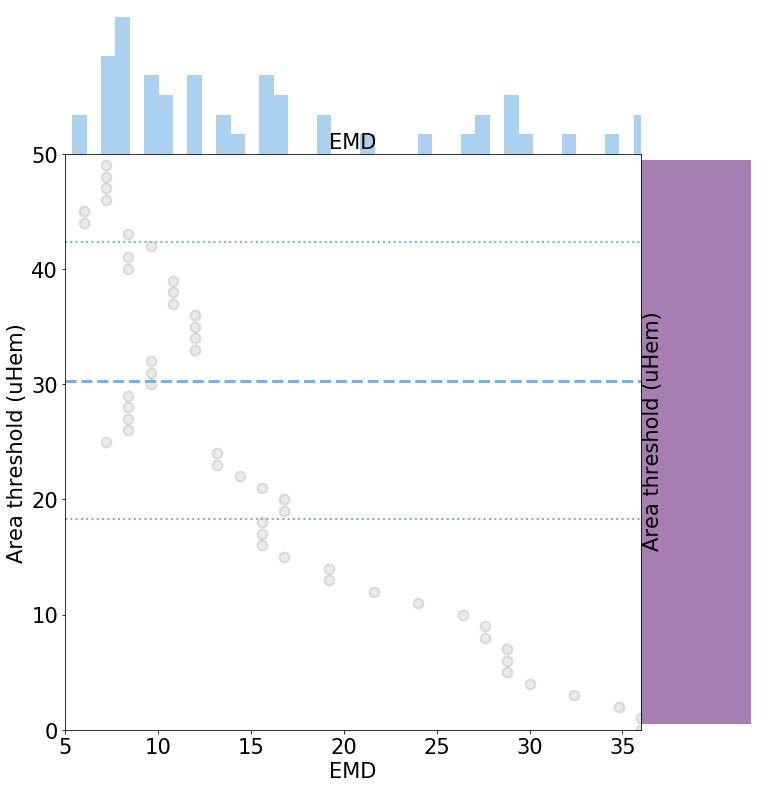

In [81]:
# Distribution Plots of threshold and distance

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Top Distribution
#EMDComb[0,:] represents the 50 lowest EMD values
axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
axd.hist(EMDComb[0,:], bins= (np.arange(0,42)-0.5)/40*(np.ceil(np.max(EMDComb[0,:]))-np.floor(np.min(EMDComb[0,:])))
         +np.floor(np.min(EMDComb[0,:])),  color=Clr[4], alpha=.6, normed = True);

# Axes properties
axd.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = np.ceil(np.max(EMDComb[0,:])))
axd.set_axis_off()


# Right Distribution
#EMDComb[1,:] represents the threshold corresponding to the 50 lowest EMD values
ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
ax2.hist(EMDComb[1,:], bins = np.arange(0,thN)*thI+thI/2,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);
# ax2.plot(yOD, xOD, color=Clr[2], linewidth=3)

# # Axes properties
ax2.set_ylim(bottom = 0, top = thN*thI)
ax2.set_axis_off()

# Scatter Plot
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
ax1.scatter(EMDComb[0,:], EMDComb[1,:], color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)

# Constructing weights
alph = 1-(EMDComb[0,:]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:]))

# Weighted average
#weighted average of the alph, represented by dashed line
wAv = np.sum(np.multiply(alph,EMDComb[1,:]))/np.sum(alph)

# Weighted Standard Deviation
#to calculate the standard deviation which is represented by the two dotted lines
wSD = np.sqrt(np.sum(np.multiply(alph,np.power(EMDComb[1,:]-wAv,2)))/np.sum(alph))

ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv, '--'
         , color = Clr[4], linewidth = 3)
ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv-wSD, ':'
         , color = Clr[4], linewidth = 2)
ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv+wSD, ':'
         , color = Clr[4], linewidth = 2)

# Axes properties
ax1.set_ylabel('Area threshold (uHem)')
ax1.text(1.02, 0.52,'Area threshold (uHem)', horizontalalignment='center', transform = ax1.transAxes, 
         rotation = 'vertical', verticalalignment = 'center')
ax1.set_xlabel('EMD')
ax1.text(0.5, 1.01,'EMD', horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = np.ceil(np.max(EMDComb[0,:])))
ax1.set_ylim(bottom = 0, top = thN*thI);

FIGURE: Scatterplot of the optimal EMD distance vs. optimal thresholds, as well as their marginal distributions. The thick blue line shows the average threshold weighted by distance and the thin blue lines show its weighted standard deviation.

## Scatterplot of Overlapping Reference and Calibrated days

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


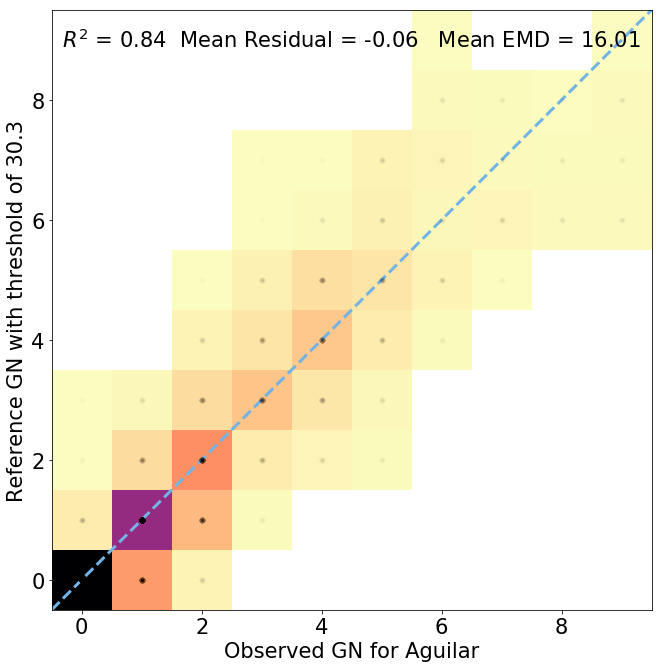

In [82]:
## Test if there is any overlap
if ( np.min(REF_Dat['ORDINAL'])<=np.min(ObsDat['ORDINAL']) ) or ( np.max(REF_Dat['ORDINAL'])>=np.max(ObsDat['ORDINAL']) ):
    
    # Calculating number of groups in reference data for given threshold
    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
    
    # Selecting the days of overlap with calibrated observer
    grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, ObsDat['ORDINAL'].values)]
    grpsObsw = ObsDat.loc[np.in1d(ObsDat['ORDINAL'].values, REF_Dat['ORDINAL'].values),'GROUPS'].values
    
    # Removing NaNs    
    grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
    grpsObsw = grpsObsw[np.isfinite(grpsObsw)]
    
    grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
    grpsREFw = grpsREFw[np.isfinite(grpsREFw)]
    
    
    # Calculating goodness of fit of Y=X
    
    # R squared
    yMean = np.mean(grpsREFw)    
    SStot = np.sum(np.power(grpsREFw-yMean,2)) 
    SSreg = np.sum(np.power(grpsREFw-grpsObsw,2))
    rSq   = 1 - SSreg/SStot
    
    # Mean Residual
    mRes = np.mean(grpsREFw-grpsObsw)
    
    plt.rc('font', **font)
    
    # Size definitions
    dpi = 300
    pxx = 2500   # Horizontal size of each panel
    pxy = pxx    # Vertical size of each panel

    nph = 1      # Number of horizontal panels
    npv = 1      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 0 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


    maxN = np.max([np.nanmax(grpsREFw),np.nanmax(ObsDat['GROUPS'].values)]) 
    #maxN is equal to 18
    
    # Average group number 
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
    ax1.hist2d(grpsObsw, grpsREFw, bins=np.arange(0,np.ceil(maxN)+1)-0.5, cmap=plt.cm.magma_r,cmin=1)
    ax1.scatter(grpsObsw, grpsREFw, color='k', edgecolor='k', s=10, linewidths = 3, zorder=11, alpha=0.01)
    ax1.plot(np.array([-0.5, maxN]), np.array([-0.5,maxN]), '--'
             , color = Clr[4], linewidth = 3)

    ax1.text(0.5, 0.95,'$R^2$ = ' + str(np.round(rSq,decimals=2)) + '  Mean Residual = ' + str(np.round(mRes,decimals=2)) + '   Mean EMD = ' + str(np.round(np.mean(EMDComb[0,:]),decimals=2)), horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)

    # Axes properties
    ax1.set_xlabel('Observed GN for ' + NamObs.capitalize())
    ax1.set_ylabel('Reference GN with threshold of ' + str(np.round(wAv,decimals=2)))
   

FIGURE: Scatterplot of the Observer vs. the reference after applying the optimal threshold obtained in the step above. Behind the scatterplot is show a color 2D histogram showing the number of points in each block. The faint dots also indicate less counts.

## Scatterplot of Overlapping Reference and Calibrated days using a different threshold for each interval

707
[1.         1.41421356 1.41421356 2.         1.73205081 1.73205081
 1.73205081 1.41421356 1.41421356 1.73205081 1.73205081 1.41421356
 1.73205081 1.41421356 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.41421356 1.41421356 1.41421356 1.73205081 1.73205081
 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.41421356 1.73205081
 1.73205081 1.41421356 1.41421356 1.73205081 1.73205081 1.41421356
 1.41421356 1.41421356 1.41421356 1.73205081 1.41421356 1.41421356
 1.41421356 1.41421356 1.73205081 1.         1.         1.
 1.         1.         1.41421356 1.41421356 1.41421356

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


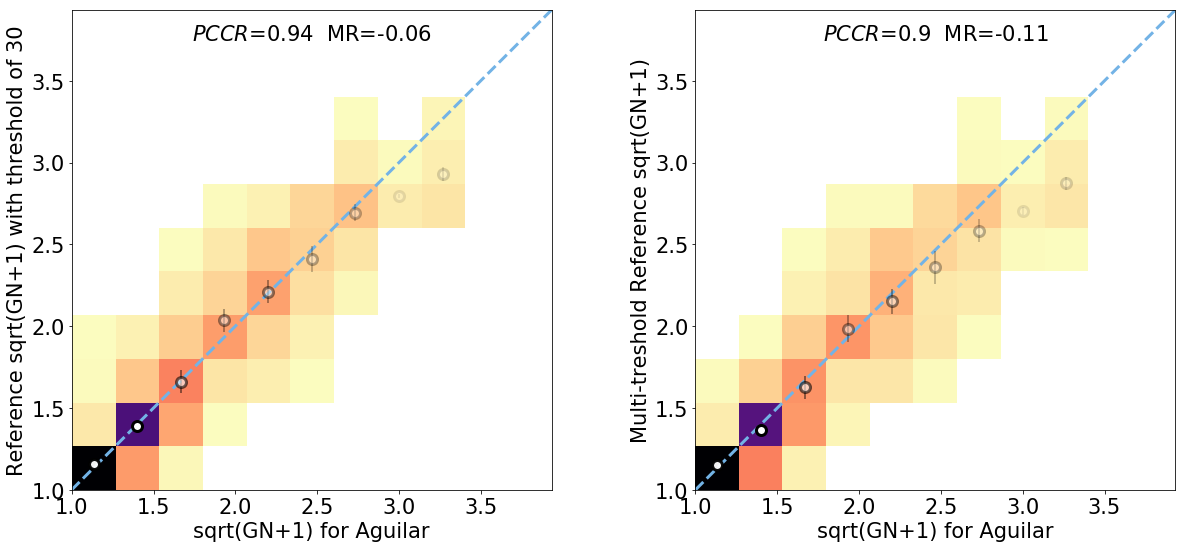

In [83]:
# Test if there is any overlap
if calRef.shape[0]>1:
        

    
    plt.rc('font', **font)
    
    # Size definitions
    dpi = 300
    pxx = 2500   # Horizontal size of each panel
    pxy = pxx    # Vertical size of each panel

    nph = 2      # Number of horizontal panels
    npv = 1      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 50 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

    
    calRefT = np.sqrt(calRef.copy()+1)
    print(len(calRefT))
    calObsT = np.sqrt(calObs.copy()+1)
    print(calObsT) 
    maxN = np.max([np.nanmax(calRefT),np.nanmax(calObsT)]) #maxN is equal to 4.242640687119285
    print(maxN)

    
    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))
    
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b1')

    calRefN = np.array([0])
    calObsN = np.array([0])
    for n in range(0,cenPoints.shape[0]):
    
        # Plot only if the period is valid and has overlap
        if vldIntr[n] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[n, 0],REF_Dat['FRACYEAR']<endPoints[n+1, 0]))>0:

            # Calculating number of groups in reference data for given threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

            # Selecting observer's interval
            TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'GROUPS'].values.copy()
            TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'ORDINAL'].values.copy()

            # Selecting the days of overlap with calibrated observer
            grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
            grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]

            # Removing NaNs    
            grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
            grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

            grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
            grpsREFw = grpsREFw[np.isfinite(grpsREFw)]


            # Appending to calibrated arrays?
            calRefN = np.append(calRefN,grpsREFw)
            calObsN = np.append(calObsN,grpsObsw)
                
    plotHistSqrtSSN(ax1, calRefN, calObsN, maxN)
    
    ax1.set_xlabel('sqrt(GN+1) for ' + NamObs.capitalize())
    ax1.set_ylabel('Reference sqrt(GN+1) with threshold of ' + str(int(np.round(wAv))))      
    
    ax1 = fig.add_axes([ppadh + (pxx/fszh+ppadh2), ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b2')


    # Calculating goodness of fit of Y=X
    
    plotHistSqrtSSN(ax1, calRef, calObs, maxN)
    
    # Axes properties
    ax1.set_xlabel('sqrt(GN+1) for ' + NamObs.capitalize())
    ax1.set_ylabel('Multi-treshold Reference sqrt(GN+1)')
  

FIGURE: Scatterplot of the Observer vs. the reference. As opposed to the one above, this scatter plot uses different thresholds for different intervals. The scatterplot is performed by merging all the scatterplots shown in the Figure Above

Behind the scatterplot is show a color 2D histogram showing the number of points in each block. The faint dots also indicate less counts.

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in greater


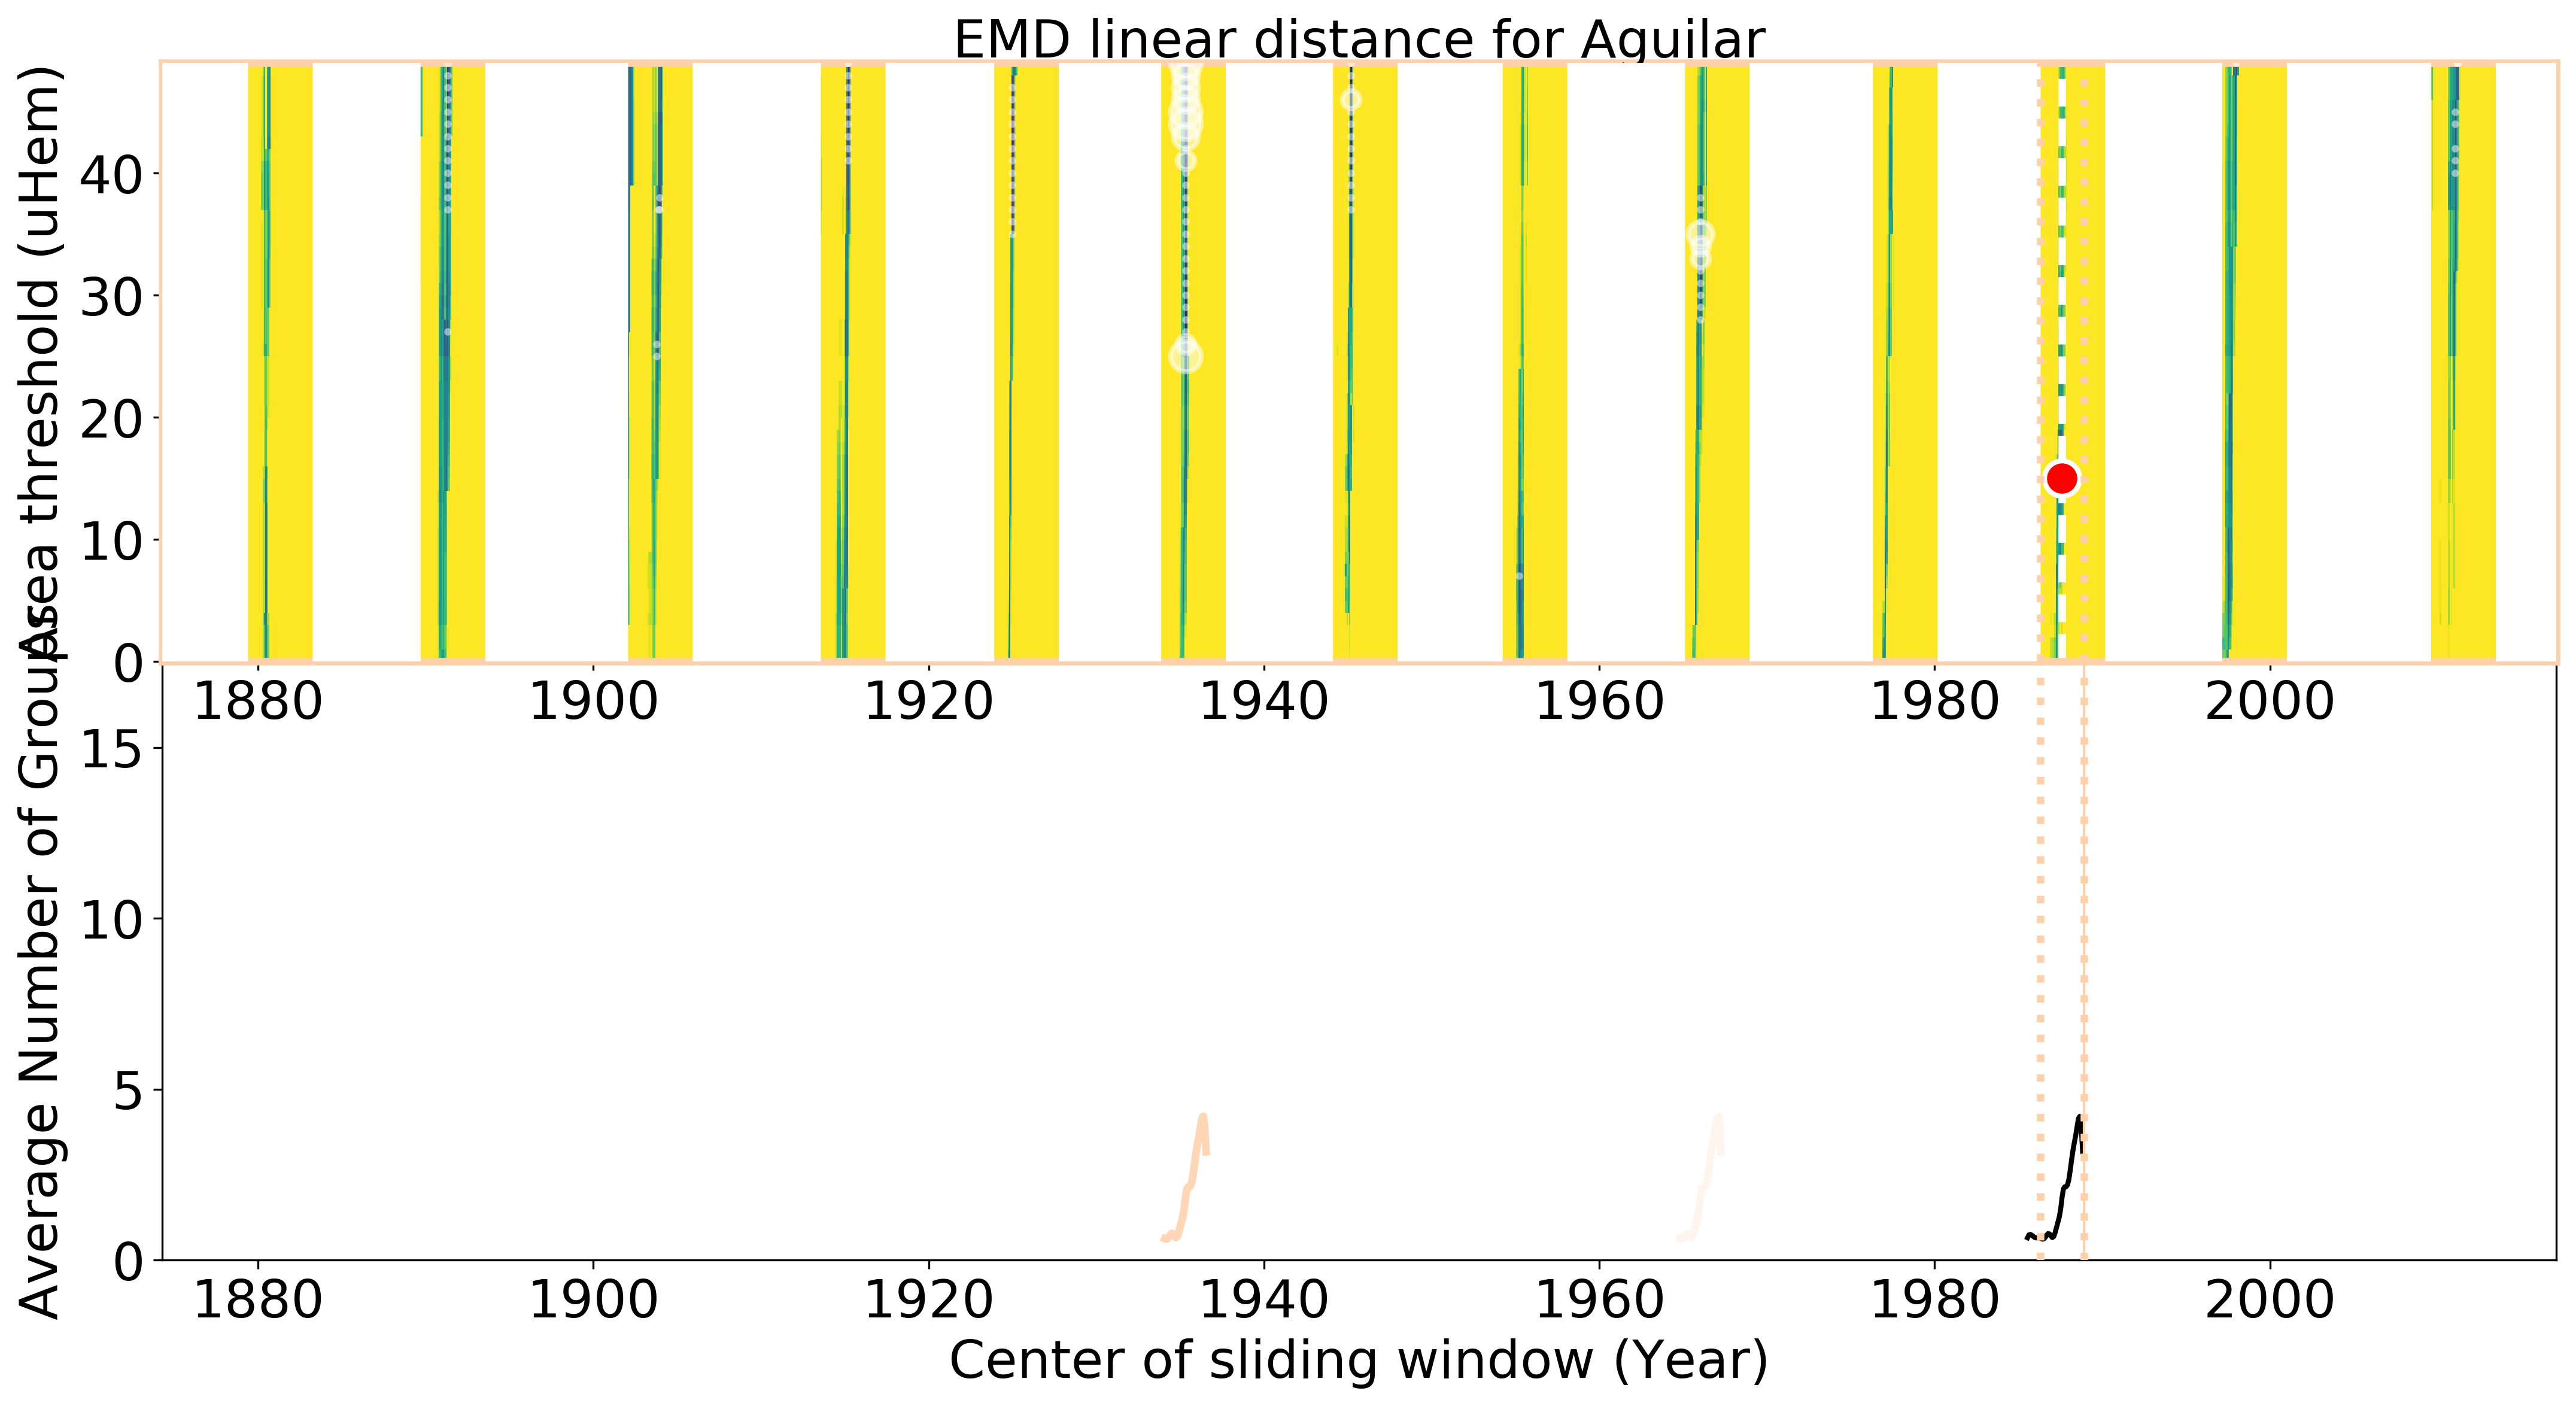

In [84]:

# Number of top best matches to keep
nBest = 50

# Creating Storing dictionaries to store best thresholds
bestTh = []

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel

nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels -> length for centerpoints of given observer (3 in this case) + 1

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


pltx = (fyr1Ob+fyr2Ob)/2

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
#ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1) # plot RGO series in bottom panel

# Plotting Observer
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2) #plot given observer series in bottom panel


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)

# EMD Pcolor
plt.viridis()

# most of this is the same that one appeared in the previous kernel
# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    # Creating axis
    ax1 = fig.add_axes([ppadh, ppadv + (siInx+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])
    
    # Defining mask based on the interval type (rise or decay)
    if cenPoints[siInx, 1] > 0:
        cadMaskI = risMaskI
        cadMask  = risMaskP
    else:
        cadMaskI = decMaskI
        cadMask  = decMaskP
        
     # Selecting interval
    #number of groups for given observer (separated by subinterval due to previous for)
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
    #print(TObsDat)
    #dates for given observer (separated by subinterval due to previous for)
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'FRACYEAR'].values.copy()
    #print(TObsFYr)
    #ordinals for given observer (separated by subinterval due to previous for)
    TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'ORDINAL'].values.copy()  
            
    TObsSNd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'AVGSNd'].values.copy()    
    
    # Plot Matrix Only if the period is valid
    if vldIntr[siInx]:  
            
        # Creating matrix for sorting and find the best combinations of threshold and shift
        #OpMat gives multiple row with 3 elements each one (EMD date, EMD threshold, EMD)
        OpMat = np.concatenate((EMDtD[siInx].reshape((-1,1)),EMDthD[siInx].reshape((-1,1)),EMDD[siInx].reshape((-1,1))), axis = 1)
        #print(OpMat)
        
        # Sort according to EMD to find the best matches
        # Sort according to EMD to find the best matches
        I = np.argsort(OpMat[:,2],axis = 0)
        OpMat = np.squeeze(OpMat[I,:])
        #print(OpMat)

        # Find index of minimum inside sub-interval
        minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx, 0]))
        obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx, 0])==minYear).nonzero()[0][0] #this is the center of the interval for given observer

        #Initialize varialbes to identify the optimum threshold for the period of overlap
        tmpEMD = 1e16
        tmpt   = np.nan
        tmpth  = np.nan 

        # Calculate optimum threshold for real period of overlap if it exists    
        # Check if real if interval is present in Observations
        # given observer data has overlap with RGO data (for each subinterval of the given observer data)? -> True or False
        if (TObsFYr[obsMinInx] > np.min(REF_Dat['FRACYEAR'])) and (TObsFYr[obsMinInx] < np.max(REF_Dat['FRACYEAR'])): 
            #print(TObsFYr[obsMinInx] > np.min(REF_Dat['FRACYEAR']))

            # Check if first element is present in reference
            # first ordinal for given observer data is equal to some ordinal in RGO data? -> True or False
            if np.any(REF_Dat['ORDINAL']==TObsOrd[0]):

                # Selecting the maximum integer amount of "months" out of the original data
                TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
                
                TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy() ##TObsDat are (daily) sunspot number values from an endpoint to next endpoint for given observer

                #Calculating bracketing indices
                Idx1 =  (REF_Dat['ORDINAL']==TObsOrd[0]).nonzero()[0][0]
                Idx2 = Idx1 + TgrpsOb.shape[0]
                
                TSNdREF = REF_Grp['AVGSNd'][Idx1:Idx2].values.copy()
                TSNdREF = TSNdREF.reshape((-1,MoLngt))
                #print(TSNdREF)
                
                # Going through different thresholds
                for TIdx in range(0,thN):
                #for TIdx in range(0,2):

                    # Calculating number of groups in reference data for given threshold
                    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thI) ,axis = 1).astype(float)
                    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan   
                    
                    #defining low and high solar activity level
                    #print(thI)
                    #print(TIdx*thI)
                    highth=0.18*TIdx*thI+31.8
                    if TIdx*thI>=60: 
                        lowth = 0.19333333*TIdx*thI-2.66666667
                    else:
                        lowth = 0

                    # Selecting the maximum integer amount of "months" out of the original data
                    TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
                    
                    TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

                    #Selecting reference window of matching size to observer sub-interval;
                    TgrpsREF = grpsREFw[Idx1:Idx2].copy()                

                    # Reshaping into "months"
                    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            
                    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))
                    
                    TObsSNd = TObsSNd.reshape((-1,MoLngt))   #(daily) sunspot number for subinterval using given observer. length = 57 months (30 data per elements)        

                    # Imprinting missing days
                    # OBSERVER
                    TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                    # REFERENCE
                    TgrpsREF[np.isnan(TgrpsOb)] = np.nan

                    # Number of days with groups
                    # OBSERVER
                    GDObsT = np.sum(np.greater(TgrpsOb,0),axis=1)
#                    print(GDObsT)
                    # REFERENCE
                    GDREFT = np.sum(np.greater(TgrpsREF,0),axis=1)

                    # Number of days with observations
                    # OBSERVER
                    ODObsT = np.sum(np.isfinite(TgrpsOb),axis=1)
                    # REFERENCE
                    ODREFT = np.sum(np.isfinite(TgrpsREF),axis=1)
#                    print(ODObsT)
                    
                    # Number of quiet days
                    # OBSERVER
                    QDObsT = ODObsT-GDObsT
                    # REFERENCE
                    QDREFT = ODREFT-GDREFT
#                    print(QDObs[0,0])
                    #print(QDObsT)

                    
                    # monthly (from daily) sunspot number
                    #SNdObs[TIdx,SIdx,:] = np.mean(np.isfinite(TObsSNd),axis=1)
                    #remove "[TIdx,SIdx,:]" for SNdObs and ADFObs/ADFREF and "[TIdx,SIdx]" for the remaining
                    SNdObsT = np.mean(TObsSNd,axis=1)                   
                    SNdREFT = np.mean(TSNdREF,axis=1)
                    #print(SNdObsT[0])
                    #print(SNdREFT[0])
                    
#                    lowval=SNdObs[np.where(SNdObs<50)]
#                    print(lowval)
#                    lowpos=np.where(SNdObs<50)
#                    print(lowpos)
#                    medval=SNdObs[np.where((50<SNdObs) & (SNdObs<100))]
#                    print(medval)
#                    medpos=np.where((50<SNdObs) & (SNdObs<100))
#                    print(medpos)
#                    highval=SNdObs[np.where(SNdObs>=100)]
#                    print(highval)
#                    highpos=np.where(SNdObs>=100)
#                    print(highpos)
                    
#                    print(GDObs[TIdx,SIdx])
#                    print('low activity level')
#                    print(GDObs[TIdx,SIdx][lowpos])
#                    ADFObslT=GDObsT[lowpos]/MoLngt
#                    ADFREFlT=GDREFT[lowpos]/MoLngt
#                    print('medium activity level')
#                    print(GDObs[TIdx,SIdx][medpos])
#                    print(ODObs[TIdx,SIdx][medpos])
#                    ADFObsmT=GDObsT[medpos]/ODObsT[medpos]
#                    ADFREFmT=GDObsT[medpos]/ODREFT[medpos]
#                    print('high activity level')
#                    print(QDObs[TIdx,SIdx][highpos])
#                    ADFObshT=(MoLngt-QDObsT[highpos])/MoLngt
#                    ADFREFhT=(MoLngt-QDREFT[highpos])/MoLngt
                    
#                    ADFObsoldT=np.concatenate([ADFObslT,ADFObsmT,ADFObshT])
#                    ADFREFoldT=np.concatenate([ADFREFlT,ADFREFmT,ADFREFhT])


                    LMObs=SNdObsT<lowth
                    LMRef=SNdREFT<lowth
#                    lowval=SNdObs[lowmsk]
#                    print(lowmsk)
#                    print(lowval)
                    MMObs=np.logical_and((lowth<SNdObsT), (SNdObsT<highth))
                    MMRef=np.logical_and((lowth<SNdREFT), (SNdREFT<highth))
#                    medval=SNdObs[medmsk]
#                    medval=SNdObs[TIdx,SIdx][np.where((50<SNdObs[TIdx,SIdx]) & (SNdObs[TIdx,SIdx]<100))]
#                    print(medmsk)
#                    print(medval)
                    HMObs=(SNdObsT>=highth)
                    HMRef=(SNdREFT>=highth)
                    #highval=SNdObs[TIdx,SIdx][np.where(SNdObs[TIdx,SIdx]>=100)]
#                    print(highval)
                    
#                    print(highpos)
                    
#                    print(GDObs[TIdx,SIdx])
#                    print('low activity level')
#                    print(GDObs[TIdx,SIdx][lowpos])
                    ADFObs=GDObsT/MoLngt
                    ADFREF=GDREFT/MoLngt
#                    print('medium activity level')
#                    print(GDObs[TIdx,SIdx][medpos])
#                    print(ODObs[TIdx,SIdx][medpos])
                    ADFObs[MMObs]=GDObsT[MMObs]/ODObsT[MMObs]
                    ADFREF[MMRef]=GDObsT[MMRef]/ODREFT[MMRef]
#                    print('high activity level')
#                    print(QDObs[TIdx,SIdx][highpos])
                    ADFObs[HMObs]=(MoLngt-QDObsT[HMObs])/MoLngt
                    ADFREF[HMRef]=(MoLngt-QDREFT[HMRef])/MoLngt
        
                    #print(ADFObslT)
                    #print(ADFObsmT)
                    #print(ADFObshT)
        
                    #ADFObsT=np.concatenate([ADFObslT,ADFObsmT,ADFObshT])
                    #ADFREFT=np.concatenate([ADFREFlT,ADFREFmT,ADFREFhT])
                    
                    #ADFObsT = ADFObsoldT[np.isfinite(ADFObsoldT)]
                    #ADFREFT = ADFREFoldT
                    #print(ADFObsT)
              

                    # Calculating Earth Mover's Distance
#                    ADFObs, bins = np.histogram(np.divide(
#                        GDObsT[ODObsT/MoLngt>=minObD],
#                        ODObsT[ODObsT/MoLngt>=minObD]),
#                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
#                    ADFREF, bins = np.histogram(np.divide(
#                        GDREFT[ODREFT/MoLngt>=minObD],
#                        ODREFT[ODREFT/MoLngt>=minObD]),
#                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
                    #prueba=(np.arange(0,MoLngt+2)-0.5)/MoLngt
                    #print(prueba)
                    #prueba2=np.isfinite(prueba)
                    #print(prueba2)
                    
                    # Calculating Earth Mover's Distance
                    ADFObsDis, bins = np.histogram(
                        ADFObs[ODObsT/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
                        
                    ADFREFDis, bins = np.histogram(
                        ADFREF[ODREFT/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)   
                                       
                
                    tmp = emd(ADFREFDis.astype(np.float64),ADFObsDis.astype(np.float64),Dis.astype(np.float64))

#                     #Calculating Chi-Square distance
#                     ADFObs, bins = np.histogram(GDObsT[ODObsT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)
#                     ADFREF, bins = np.histogram(GDREFT[ODREFT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)

#                     # Calculating numerator and denominator for Chi-square distance
#                     Nom = np.power(ADFObs-ADFREF,2)
#                     #Den = np.power(ADFObs,2) + np.power(ADFREF,2)
#                     Den = ADFObs + ADFREF

#                     # Removing zeros in denominator
#                     Nom = Nom[Den!=0]
#                     Den = Den[Den!=0]

#                     # Calculating Chi-square distance
#                     tmp = np.sum(np.divide(Nom,Den))

                    # Udating variables
                    if tmp<tmpEMD:
                        tmpEMD = tmp
                        tmpt   = TObsFYr[obsMinInx]
                        tmpth  = TIdx*thI


        OpMat = np.insert(OpMat,0,[tmpt,tmpth,tmpEMD],axis=0)            
            
        # Calculating mesh for plotting
        x = REF_Grp['FRACYEAR'].values[cadMaskI]
        y = np.arange(0,thN)*thI
        xx, yy = np.meshgrid(x, y)             

        #Plotting Optimization Matrix
        # to plot mesh with yellow and blue colors for the three first panels
        mesh = ax1.pcolormesh(xx,yy,EMDD[siInx], alpha = 1, linewidth = 2, vmin = np.min(EMDD[siInx]), vmax = 6*np.min(EMDD[siInx]))

            
        # True Interval
        #plot red dot corresponding to true interval
        ax1.scatter(OpMat[0,0], OpMat[0,1], c = 'r', edgecolors = 'w',linewidths = 2, s = 200, zorder=11)

        # Best 5 points
        for i in range(1,5):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 150, zorder=11, alpha = 0.5)
            ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx, 0]+OpMat[i,0]
                     , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                     , alpha = 0.2)

        # Best 5-10 points
        for i in range(5,10):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 100, zorder=11, alpha = 0.5)
            ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx, 0]+OpMat[i,0]
                     , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                     , alpha = 0.2)

        # Best 10-15 points
        for i in range(10,15):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 50, zorder=11, alpha = 0.5)

        # Best 15-20 points
        for i in range(15,100):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 1, zorder=11, alpha = 0.5)
            
        # Masking Gaps
        pltMsk  = np.logical_not(cadMask)
        ax1.fill_between(REF_Grp['FRACYEAR'],  REF_Grp['FRACYEAR']*0, y2=REF_Grp['FRACYEAR']*0+thN, where=pltMsk, color = 'w', zorder=10)

        # Adding best points
        bestTh.append(OpMat[1:nBest,:])
    
    # If period not valid store an empty array
    else:
        bestTh.append([])

    # Plotting real location
    ax1.plot(np.array([1,1])*TObsFYr[obsMinInx], np.array([0,np.max(y)]),'w--', linewidth = 3)
    
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])            
            
    # Axes properties
    ax1.set_ylabel('Area threshold (uHem)')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = 0, top = np.max(y))
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

fig.savefig(NamObs.capitalize() + '_EMD_1.png', bbox_inches='tight', dpi = 103, pad_inches=0)